# Software Project Risk Prediction: Comprehensive Exploratory Data Analysis

This notebook performs a comprehensive exploratory data analysis (EDA) on the Apache JIRA dataset to understand software project risk factors. Our goal is to analyze patterns in project metadata, issue tracking metrics, and developer behaviors to ultimately build reliable predictors for two types of risk:

1. **Schedule Risk**: Likelihood of project delays and schedule overruns
2. **Quality Risk**: Likelihood of quality issues and bug prevalence

## Table of Contents

1. [Setup and Data Loading](#section1)
2. [Dataset Overview](#section2)
3. [Project Metadata Analysis](#section3)
4. [Issue Lifecycle and Resolution Analysis](#section4)
5. [Change Activity and Volatility](#section5)
6. [Issue Priority and Type Analysis](#section6) 
7. [Schedule Risk Label Development](#section7)
8. [Quality Risk Label Development](#section8)
9. [Conclusions and Next Steps](#section9)

<a id="section1"></a>
## 1. Setup and Data Loading

First, let's import the necessary libraries and read in the Apache projects dataset.

In [48]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from upsetplot import plot as upset_plot
from upsetplot import from_indicators

# For nicer looking plots
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Configure display settings
pd.set_option('display.float_format', '{:.4f}'.format)  # Avoid scientific notation
pd.set_option('display.max_columns', None)  # Show all columns

# Load the dataset
df = pd.read_csv("./apache/train.csv")

# Drop any redundant or unused columns
unused_columns = [
    'has_time_fields', 'average_time_spent',
    'average_original_estimate', 'average_delay', 'average_delay_ratio'
]
df = df.drop(columns=unused_columns, errors='ignore')

<a id="section2"></a>
## 2. Dataset Overview

Let's first understand what we're working with by examining the dataset's structure, checking for missing values, and getting a sense of the variable distributions.

In [49]:
# Basic dataset information
print(f"Dataset dimensions: {df.shape}")
print("\nData Types:")
print(df.dtypes)

# Check for duplicates
duplicates = df.duplicated(subset="project_id").sum()
print(f"\nNumber of duplicate project_id entries: {duplicates}")

# Missing values analysis
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_ratio = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_ratio (%)": missing_ratio
})
print("\nMissing Values Summary:")
print(missing_df[missing_df["missing_count"] > 0])

# Basic descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
df.describe().T

Dataset dimensions: (492, 45)

Data Types:
project_id                             int64
project_key                           object
project_name                          object
project_category                      object
total_reopened                         int64
average_lifespan                     float64
average_workspan                     float64
average_change_density               float64
average_reassignment_rate            float64
average_description_edit_rate        float64
average_author_churn                 float64
average_fix_version_change_rate      float64
average_time_estimate_change_rate    float64
average_resolution_change_rate       float64
average_status_change_rate           float64
average_priority_change_rate         float64
average_issue_type_change_rate       float64
total_changes                          int64
total_assignees                        int64
total_reporters                        int64
total_members                          int64
total_issues

,count,mean,std,min,25%,50%,75%,max
project_id,492.0000,11139456.1484,3620465.8639,10012.0000,12310630.7500,12311422.5000,12317827.2500,12325525.0000
total_reopened,492.0000,69.0874,183.6750,0.0000,0.0000,8.0000,45.2500,1722.0000
average_lifespan,483.0000,251.2962,348.1193,0.0004,69.0604,153.0235,327.9264,4846.6863
average_workspan,492.0000,472.4521,547.2511,0.0000,147.5877,309.1061,620.0027,4975.7970
average_change_density,492.0000,230.2812,503.8818,0.0000,16.7490,68.5799,208.1355,5236.3636
average_reassignment_rate,492.0000,0.0515,0.0509,0.0000,0.0269,0.0450,0.0639,0.5588
average_description_edit_rate,492.0000,0.0251,0.0383,0.0000,0.0078,0.0188,0.0305,0.5000
average_author_churn,492.0000,0.6923,0.2182,0.0000,0.6246,0.7496,0.8333,1.0000
average_fix_version_change_rate,492.0000,0.0699,0.0637,0.0000,0.0207,0.0640,0.1005,0.5184
average_time_estimate_change_rate,492.0000,0.0023,0.0060,0.0000,0.0000,0.0001,0.0017,0.0627


<Figure size 1200x600 with 0 Axes>

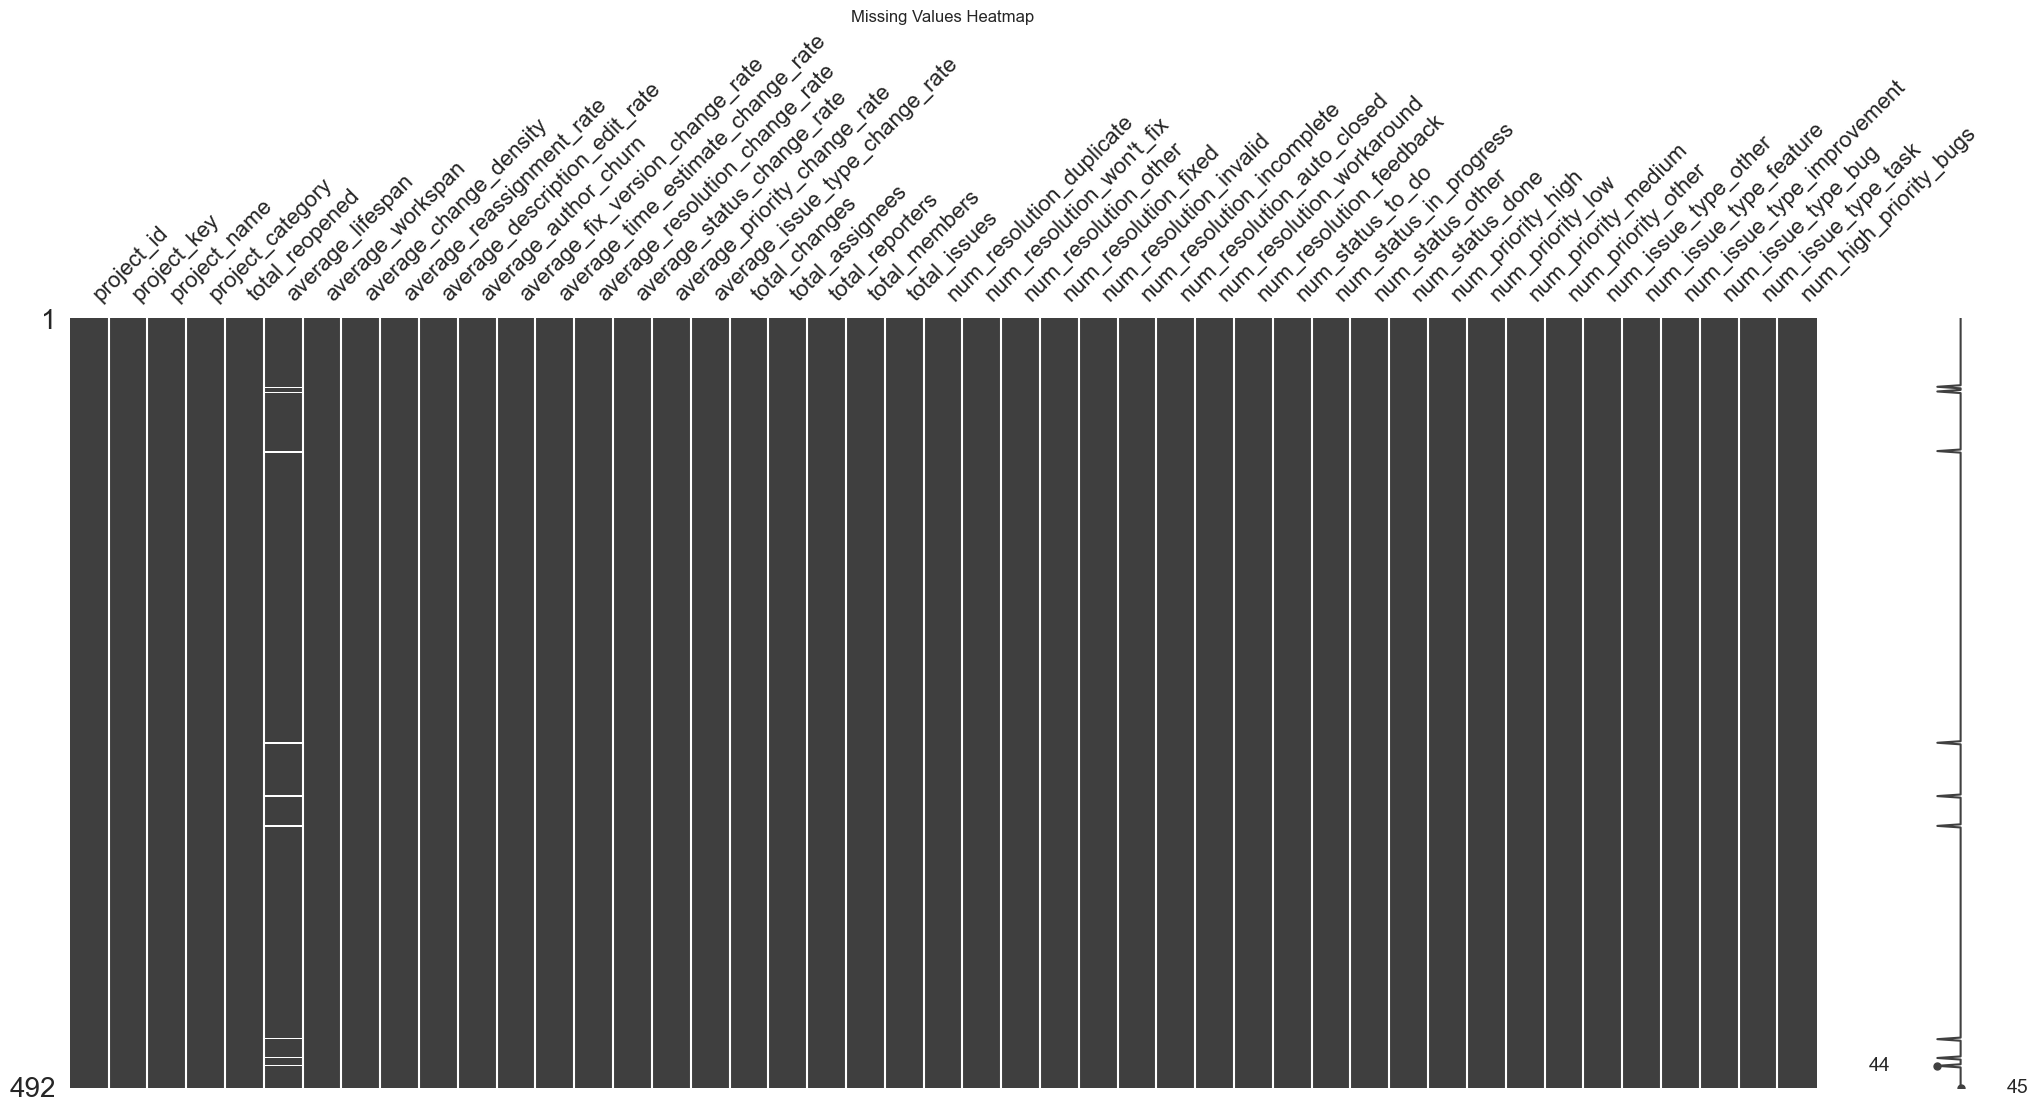

In [50]:
# Visual missing value analysis
plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

In [51]:
# First, let's look at the project names to understand the dataset
print("Number of unique projects:", df["project_name"].nunique())
print("\nSample of project names:")
print(df["project_name"].sample(10).values)

Number of unique projects: 492

Sample of project names:
['DocBook Framework' 'Stomp Specification' 'Velocity Sandbox' 'TOREE'
 'Nutch' 'Celix' 'Usergrid (Retired)' 'XalanC' 'Forrest (Retired)'
 'Spatial Information Systems']


In [52]:
# Let's address the missing values in the 'average_lifespan' column
# Some projects may not have an average lifespan recorded, because none of their issues were closed.
# This may suggest that the project is either stalled or very new.

# How to fill?
# 0? May not be appropriate as it suggests no lifespan, which is misleading.
# A large value (e.g. double of the maximum lifespan in the dataset)? Good for stalled projects, but not for new projects.
# Use the median lifespan as a reasonable estimate for missing values
median_lifespan = df['average_lifespan'].median()
df['average_lifespan'].fillna(median_lifespan * 2, inplace=True) # Assuming stalled projects have double the median lifespan

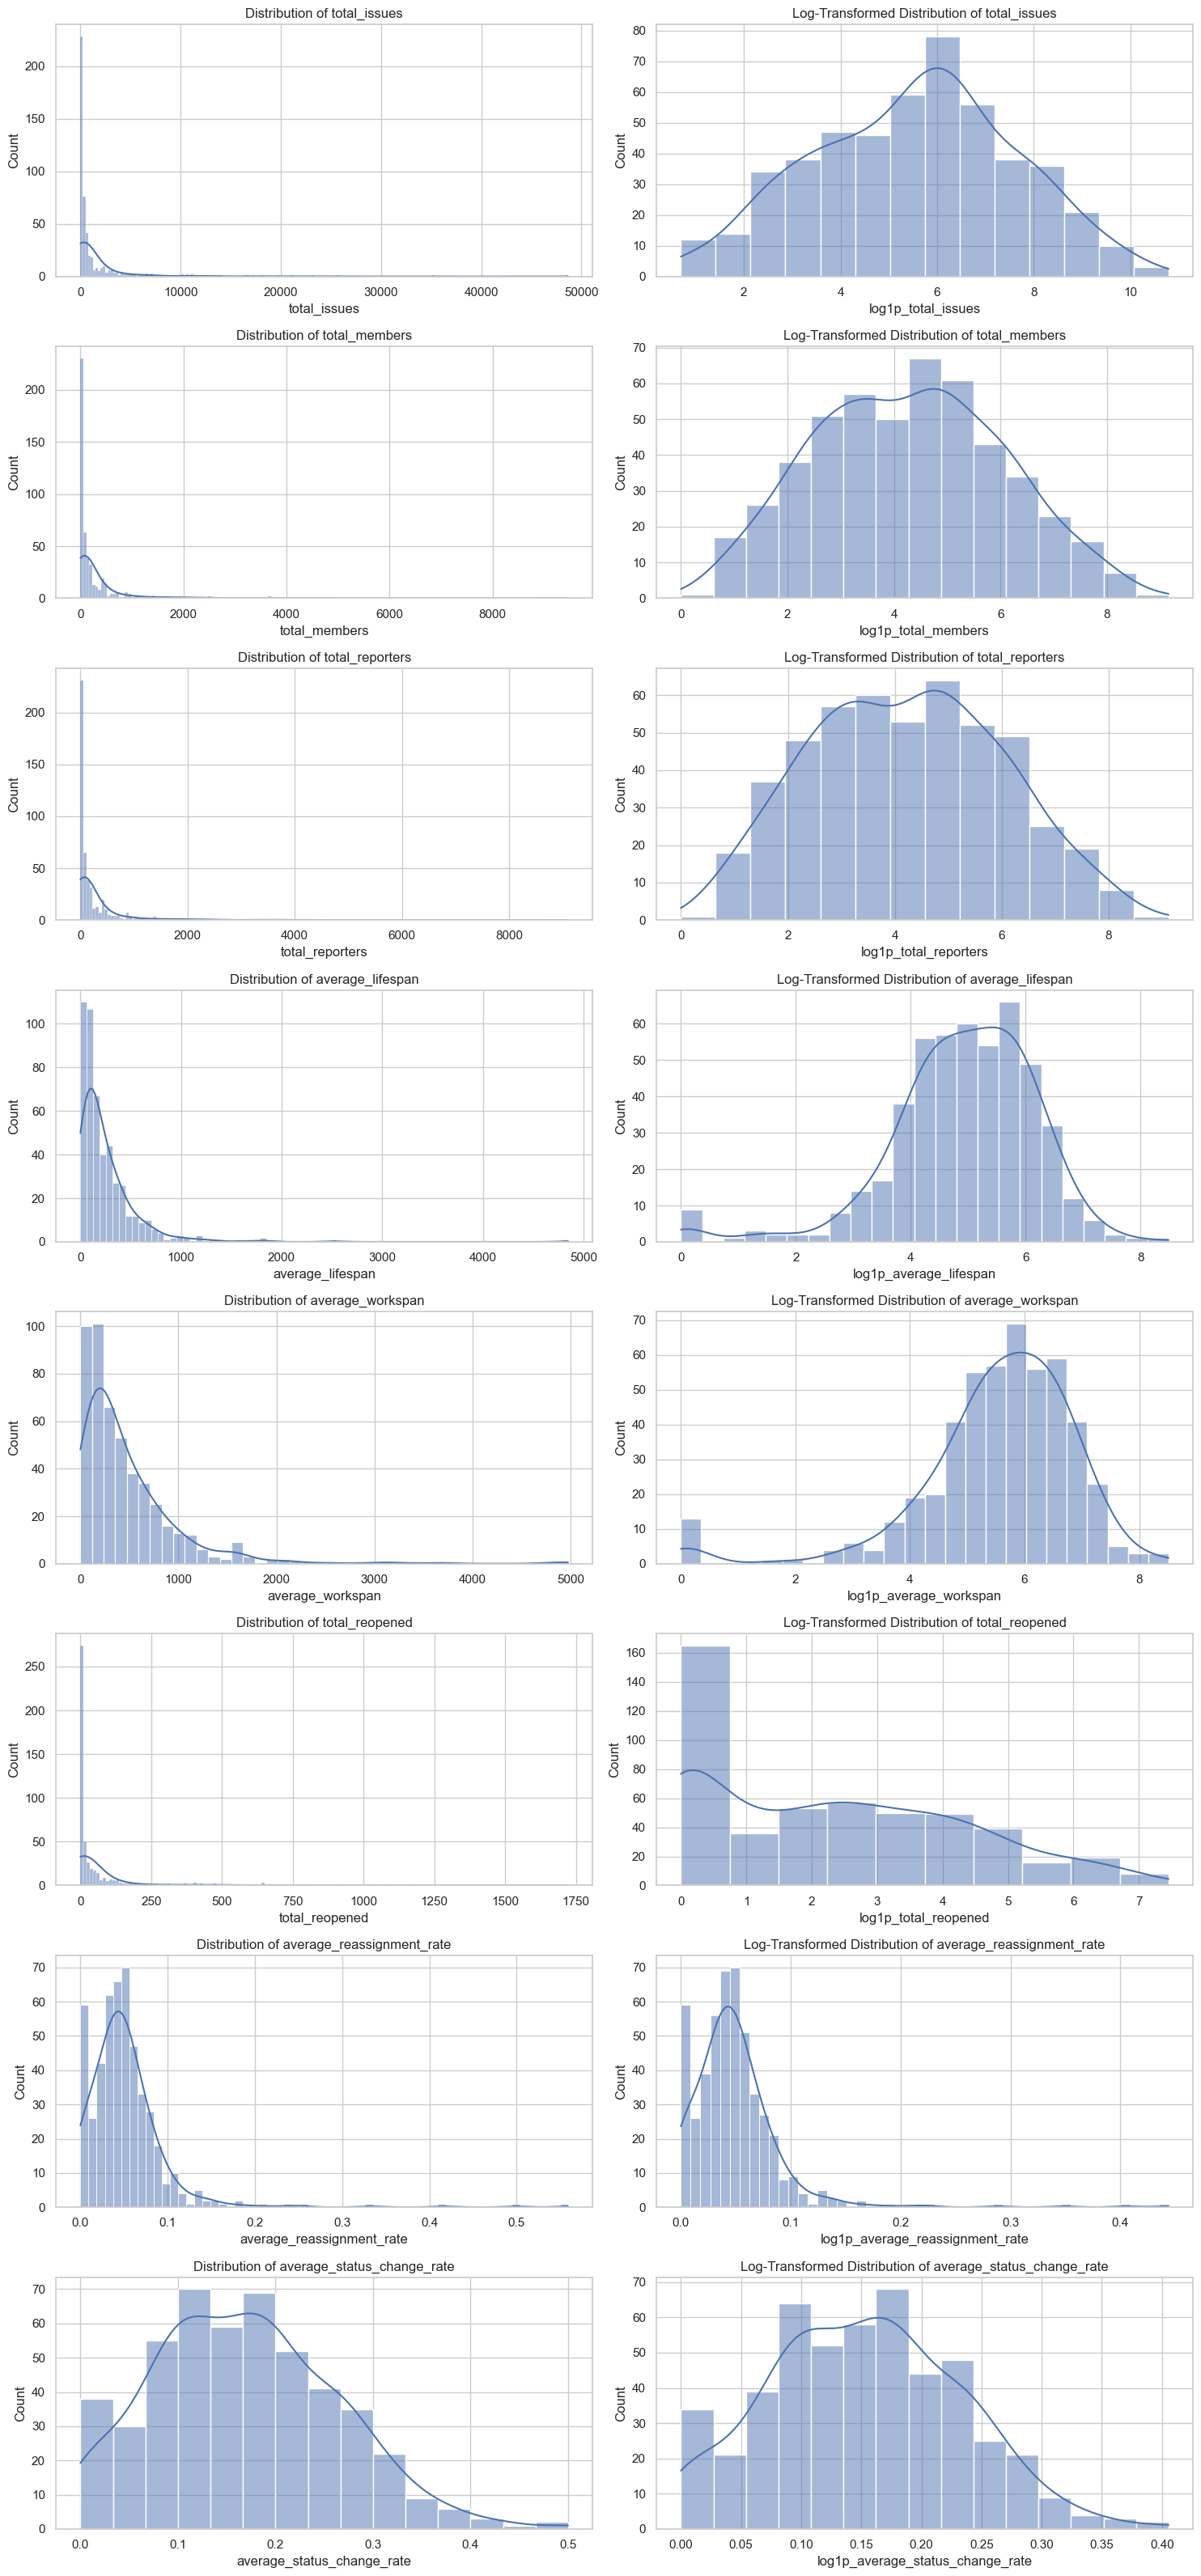

In [53]:
# Let's look at the distribution of key numerical variables
numerical_features = ['total_issues', 'total_members', 'total_reporters', 
                      'average_lifespan', 'average_workspan',
                      'total_reopened', 'average_reassignment_rate', 'average_status_change_rate']

# Add log-transformed features for heavily skewed distributions
for col in numerical_features:
    if col in df.columns:
        df[f'log1p_{col}'] = np.log1p(df[col])

# Create histograms for numerical features
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(15, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    if feature in df.columns:
        # Original distribution
        sns.histplot(df[feature], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {feature}')
        
        # Log-transformed distribution
        sns.histplot(df[f'log1p_{feature}'], kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Log-Transformed Distribution of {feature}')

plt.tight_layout()
plt.show()

<a id="section3"></a>
## 3. Project Metadata Analysis

In this section, we'll analyze the metadata of the projects, such as project size metrics (number of issues, members, reporters), project categories, and their distributions. This will help us understand the diversity of the projects in our dataset.

In [54]:
# Examine project size metrics
size_metrics = ['total_issues', 'total_members', 'total_assignees', 'total_reporters']

# Calculate summary statistics by project category
category_summary = df.groupby('project_category')[size_metrics].agg(['mean', 'median', 'count'])
print("Project Size Metrics by Category:")
print(category_summary)

Project Size Metrics by Category:
                                       total_issues                  \
                                               mean    median count   
project_category                                                      
Big Data & Analytics                      5053.6250 1782.0000    64   
Build, Release, & Project Management       467.0000  221.5000    62   
Cloud & Virtualization                    1841.4444 1042.0000     9   
Community & Administrative                 151.1429   22.0000     7   
Content Management & XML                  3322.2500  450.0000     4   
Databases & Persistence                   3418.6316  772.0000    19   
Geospatial                                 629.0000  629.0000     2   
Graphics & Imaging                        3061.0000 3201.0000     3   
Incubator & Retired/Dormant Projects       560.2907  228.0000    86   
IoT & Edge Computing                      3304.6000  237.0000     5   
Libraries & Utilities (Commons & Core)     

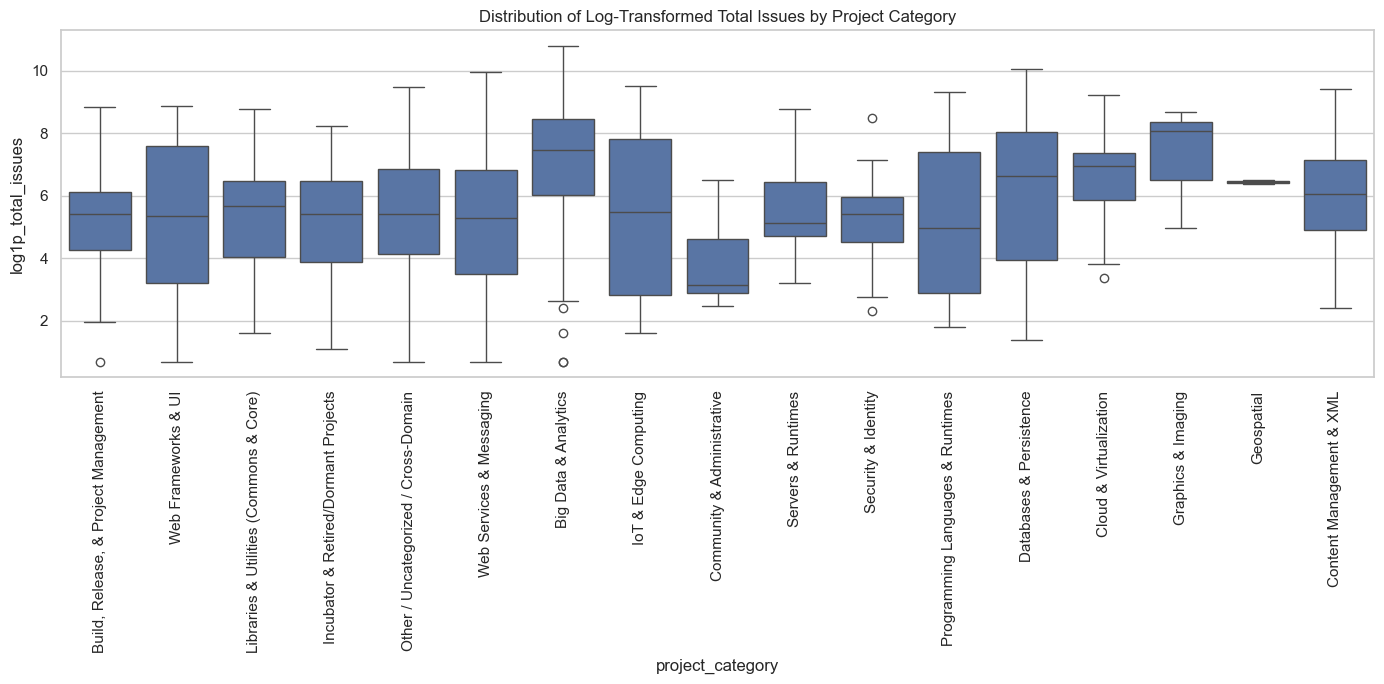

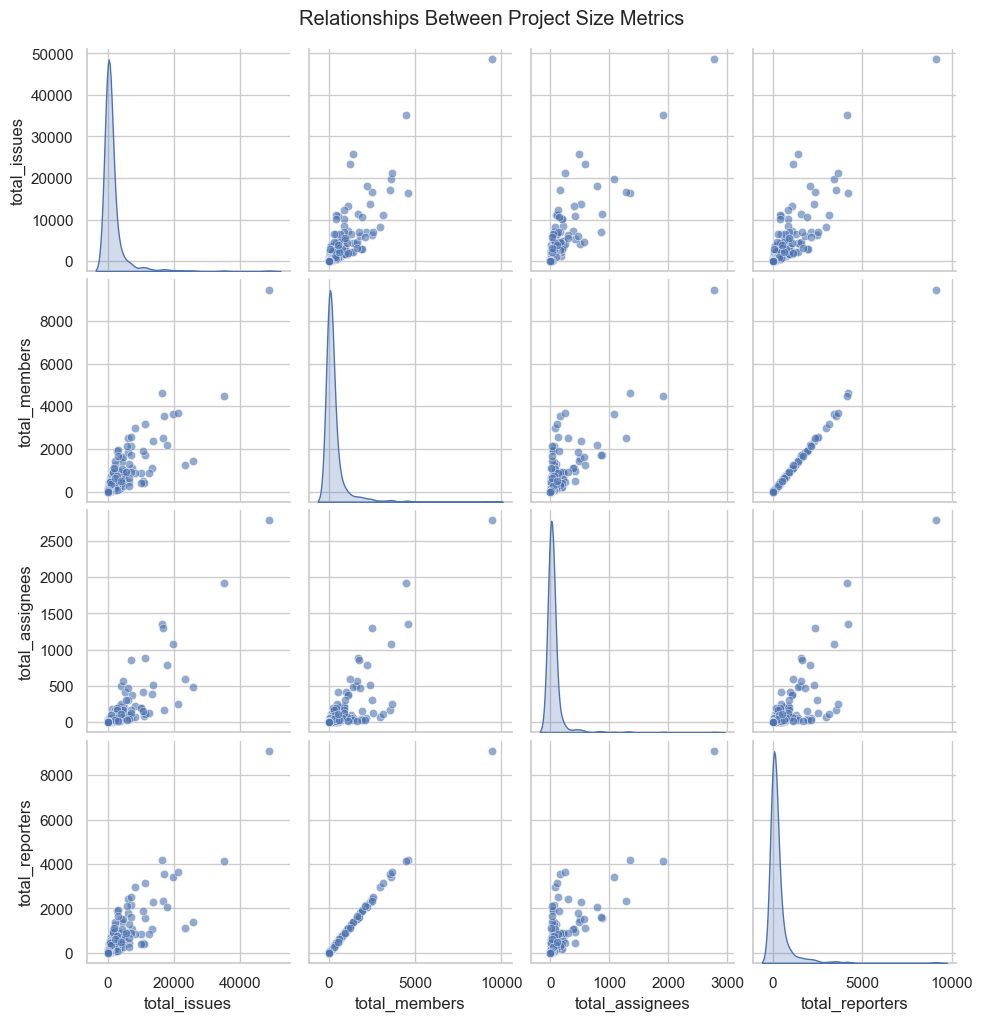

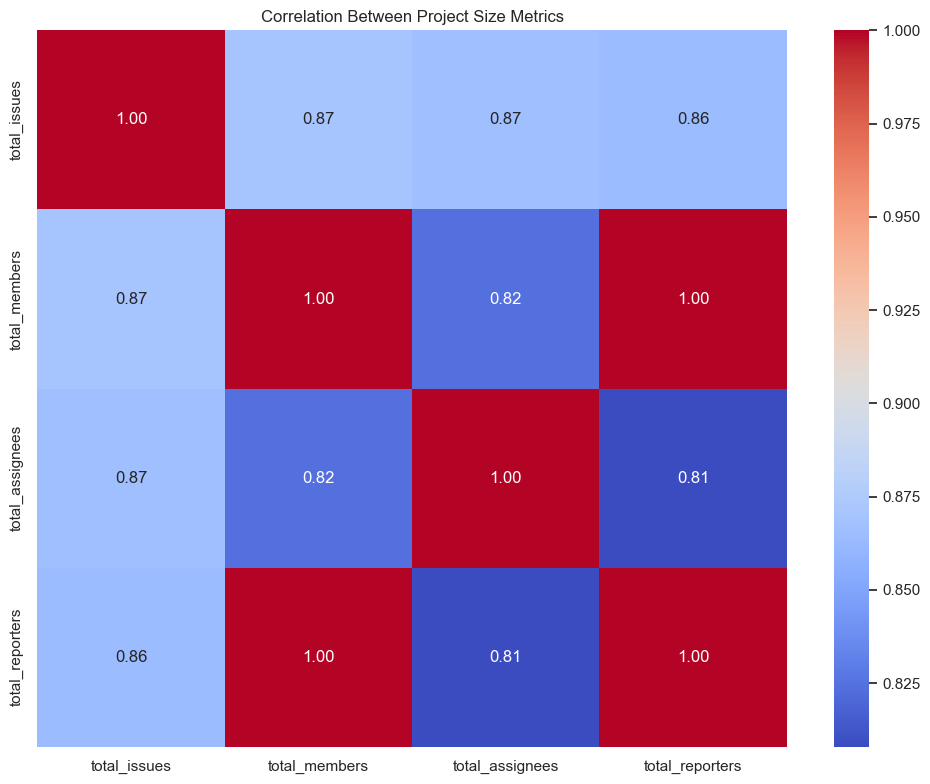

In [55]:
# Visualize distributions of size metrics by project category using box plots
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='project_category', y='log1p_total_issues')
plt.xticks(rotation=90)
plt.title('Distribution of Log-Transformed Total Issues by Project Category')
plt.tight_layout()
plt.show()

# Examine relationships between size metrics
sns.pairplot(
    df,
    vars=size_metrics,
    diag_kind='kde',
    plot_kws={'alpha': 0.6}
)
plt.suptitle('Relationships Between Project Size Metrics', y=1.02)
plt.show()

# Correlation among size metrics
plt.figure(figsize=(10, 8))
size_corr = df[size_metrics].corr()
sns.heatmap(size_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Project Size Metrics')
plt.tight_layout()
plt.show()

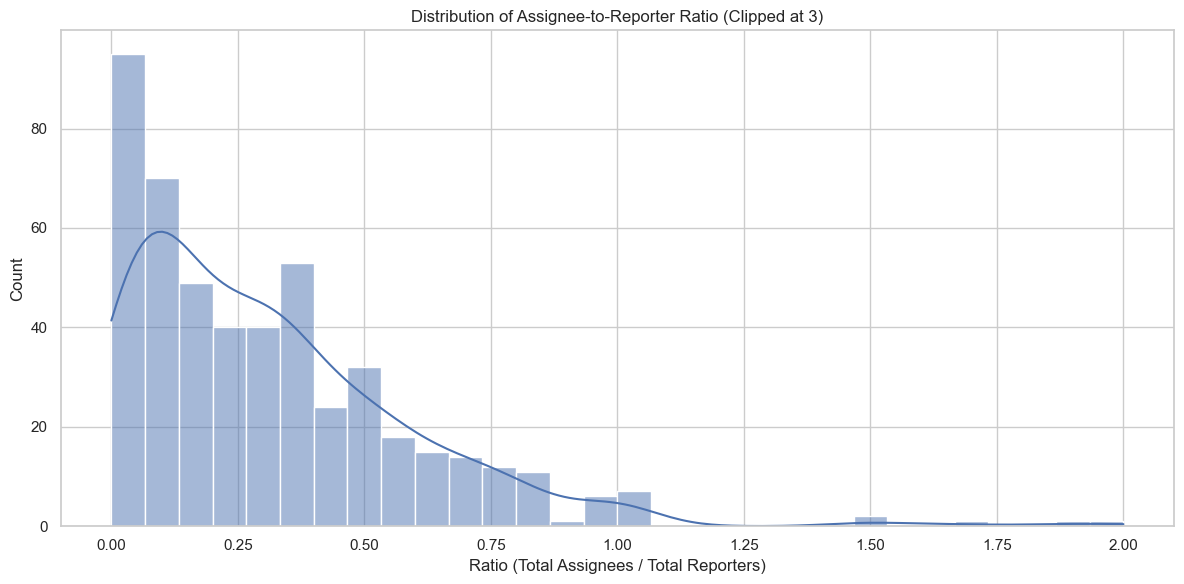

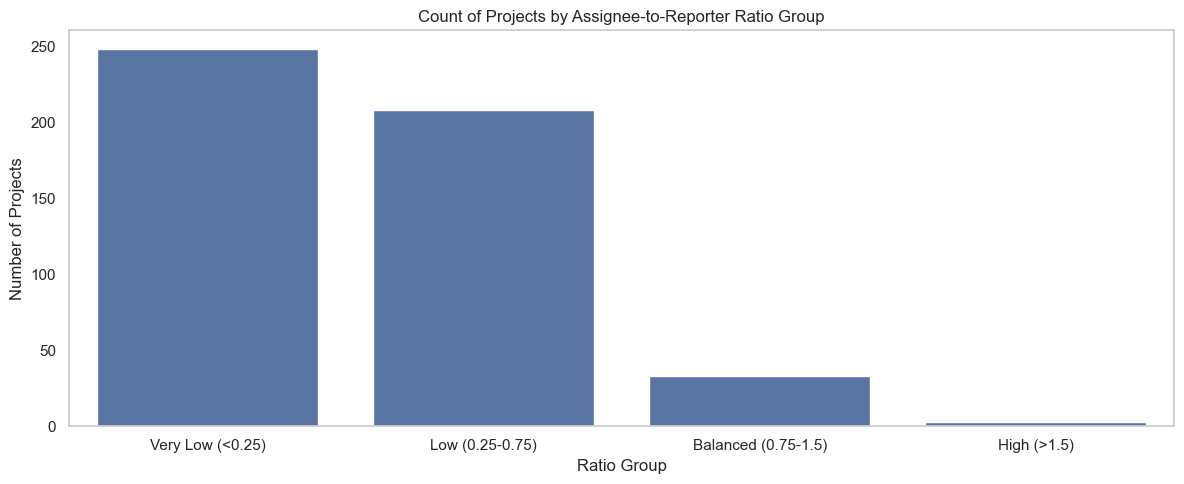

In [56]:
# Calculate and visualize assignee-to-reporter ratio
df['assignee_reporter_ratio'] = df['total_assignees'] / (df['total_reporters'] + 1e-5)

plt.figure(figsize=(12, 6))
sns.histplot(df['assignee_reporter_ratio'].clip(0, 3), bins=30, kde=True)
plt.title('Distribution of Assignee-to-Reporter Ratio (Clipped at 3)')
plt.xlabel('Ratio (Total Assignees / Total Reporters)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create categorical bins for better analysis
df['assignee_reporter_group'] = pd.cut(
    df['assignee_reporter_ratio'],
    bins=[-0.01, 0.25, 0.75, 1.5, float('inf')],
    labels=['Very Low (<0.25)', 'Low (0.25-0.75)', 'Balanced (0.75-1.5)', 'High (>1.5)']
)

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='assignee_reporter_group')
plt.title('Count of Projects by Assignee-to-Reporter Ratio Group')
plt.xlabel('Ratio Group')
plt.ylabel('Number of Projects')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<a id="section4"></a>
## 4. Issue Lifecycle and Resolution Analysis

This section examines how issues progress through their lifecycle, their resolution patterns, and the time they spend in various states. Understanding these patterns is key to identifying potential schedule risks.

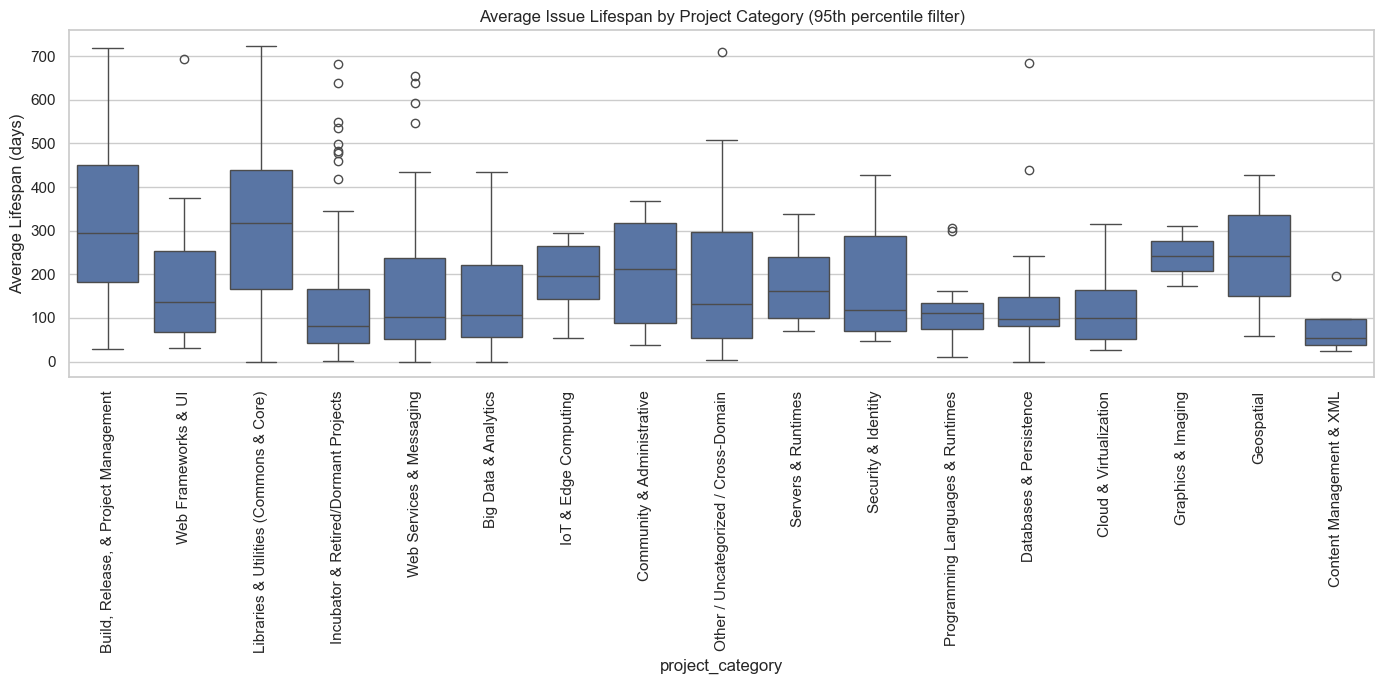

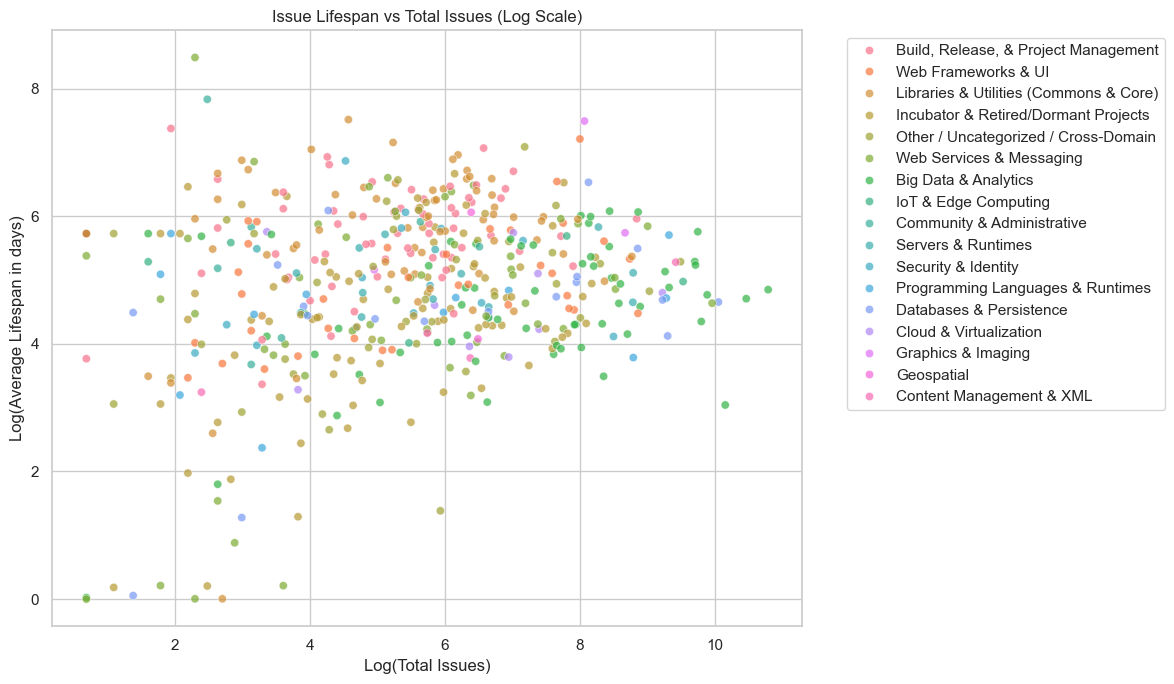

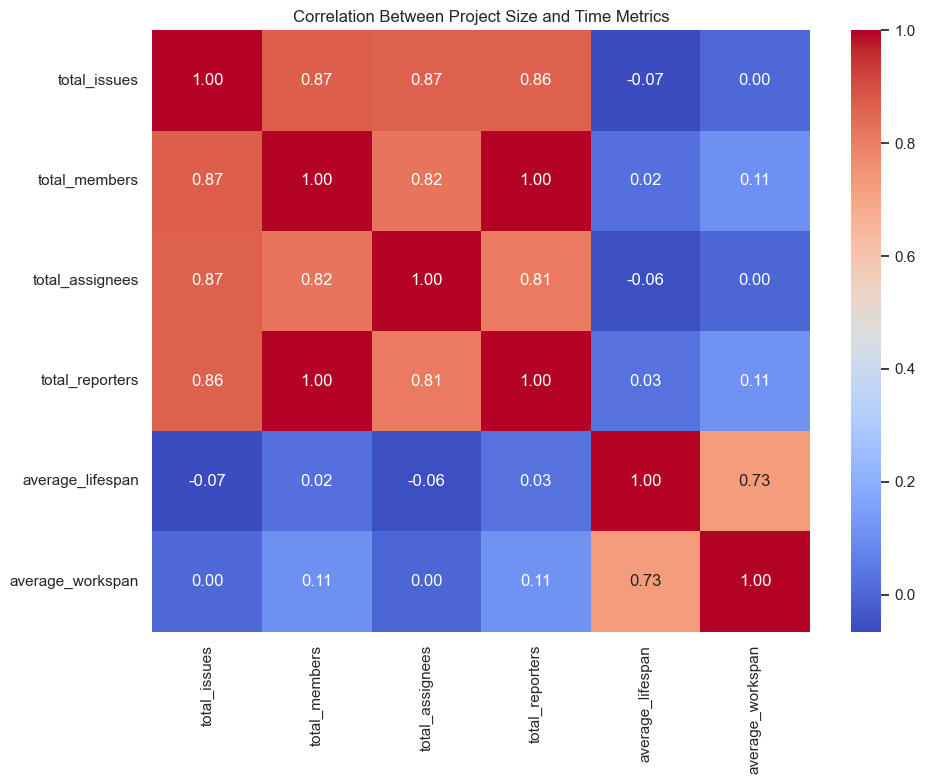

In [57]:
# Examine the lifespan and workspan of issues
time_metrics = ['average_lifespan', 'average_workspan']

# Create box plots for lifespan distribution by category
plt.figure(figsize=(14, 7))

# Filter outliers for better visualization
lifespan_upper = df['average_lifespan'].quantile(0.95)
filtered_df = df[df['average_lifespan'] <= lifespan_upper]

sns.boxplot(data=filtered_df, x='project_category', y='average_lifespan')
plt.xticks(rotation=90)
plt.title('Average Issue Lifespan by Project Category (95th percentile filter)')
plt.ylabel('Average Lifespan (days)')
plt.tight_layout()
plt.show()

# Scatter plot of lifespan vs. total issues
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df, 
    x='log1p_total_issues', 
    y='log1p_average_lifespan', 
    hue='project_category',
    alpha=0.7
)
plt.title('Issue Lifespan vs Total Issues (Log Scale)')
plt.xlabel('Log(Total Issues)')
plt.ylabel('Log(Average Lifespan in days)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate correlation between time metrics and size metrics
combined_metrics = size_metrics + time_metrics
correlation = df[combined_metrics].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Project Size and Time Metrics')
plt.tight_layout()
plt.show()

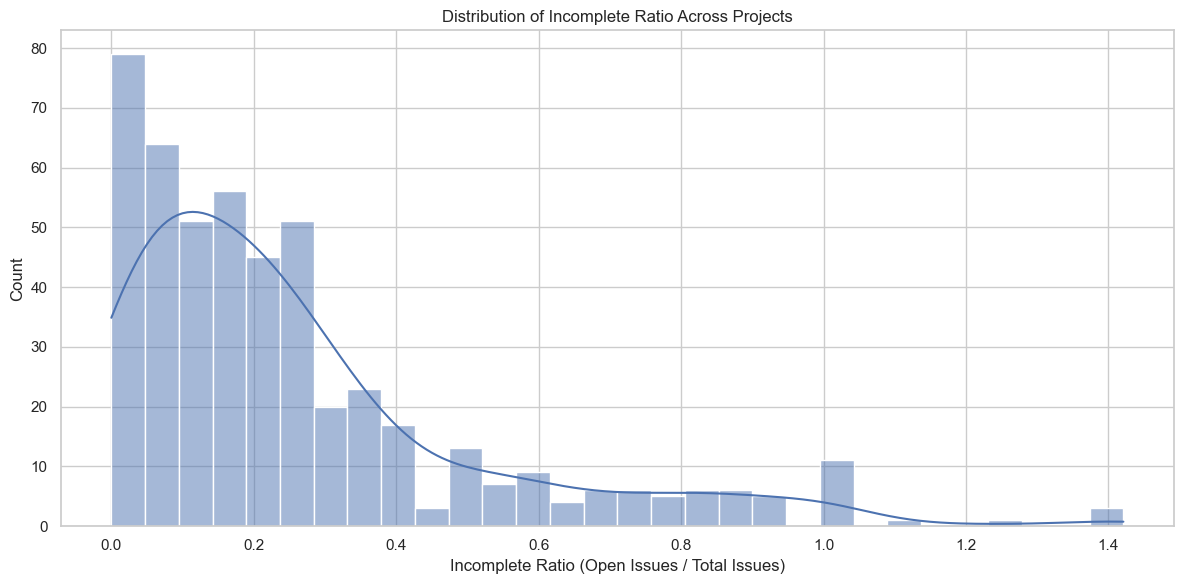

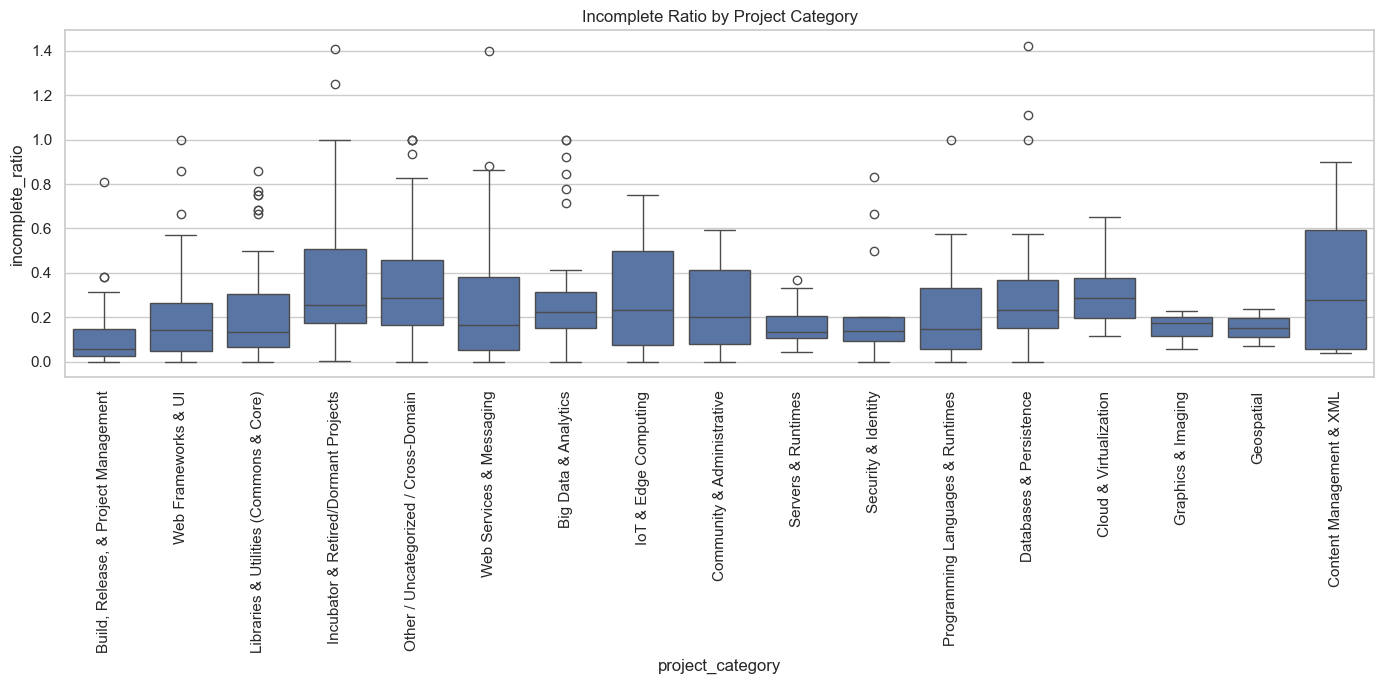

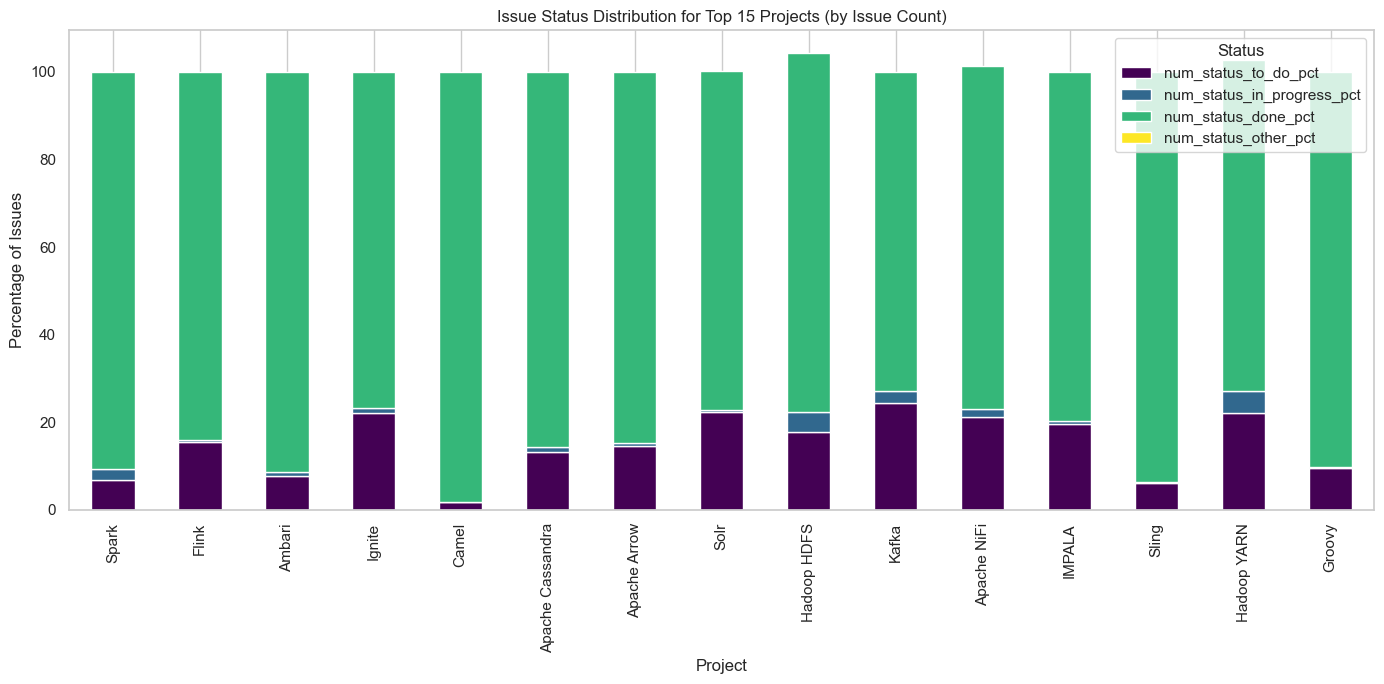

In [58]:
# Analyze issue status distribution
status_cols = ['num_status_to_do', 'num_status_in_progress', 'num_status_done', 'num_status_other']

# Calculate percentages instead of absolute counts
for col in status_cols:
    df[f"{col}_pct"] = (df[col] / df['total_issues']) * 100

# Create new consolidated columns for open issues
df['open_issues'] = df['num_status_to_do'] + df['num_status_in_progress']
df['open_issue_ratio'] = df['open_issues'] / df['total_issues']

# Create a new column for incomplete rate
df['incomplete_ratio'] = df['open_issues'] / df['total_issues']

# Plot distribution of incomplete ratio
plt.figure(figsize=(12, 6))
sns.histplot(df['incomplete_ratio'], bins=30, kde=True)
plt.title('Distribution of Incomplete Ratio Across Projects')
plt.xlabel('Incomplete Ratio (Open Issues / Total Issues)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of incomplete ratio by project category
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='project_category', y='incomplete_ratio')
plt.xticks(rotation=90)
plt.title('Incomplete Ratio by Project Category')
plt.tight_layout()
plt.show()

# Plot status distribution for top 15 projects by total issues
top15 = df.nlargest(15, 'total_issues')
status_pct_cols = [col for col in df.columns if '_pct' in col and 'status' in col]
status_df = top15[['project_name'] + status_pct_cols].set_index('project_name')

status_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 7),
    cmap='viridis'
)
plt.title('Issue Status Distribution for Top 15 Projects (by Issue Count)')
plt.xlabel('Project')
plt.ylabel('Percentage of Issues')
plt.legend(title='Status')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

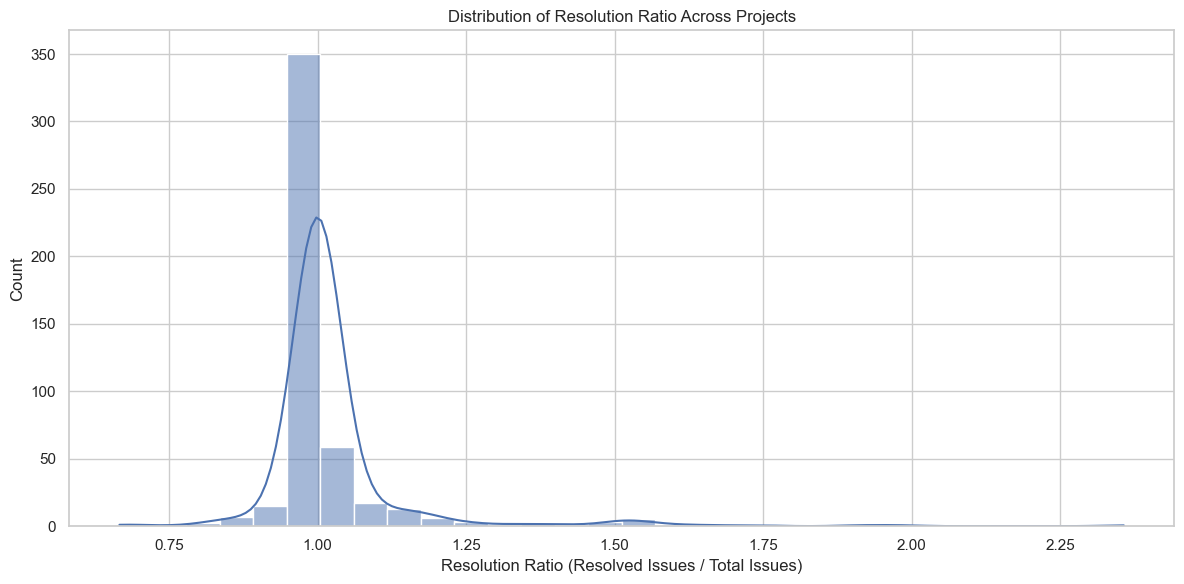

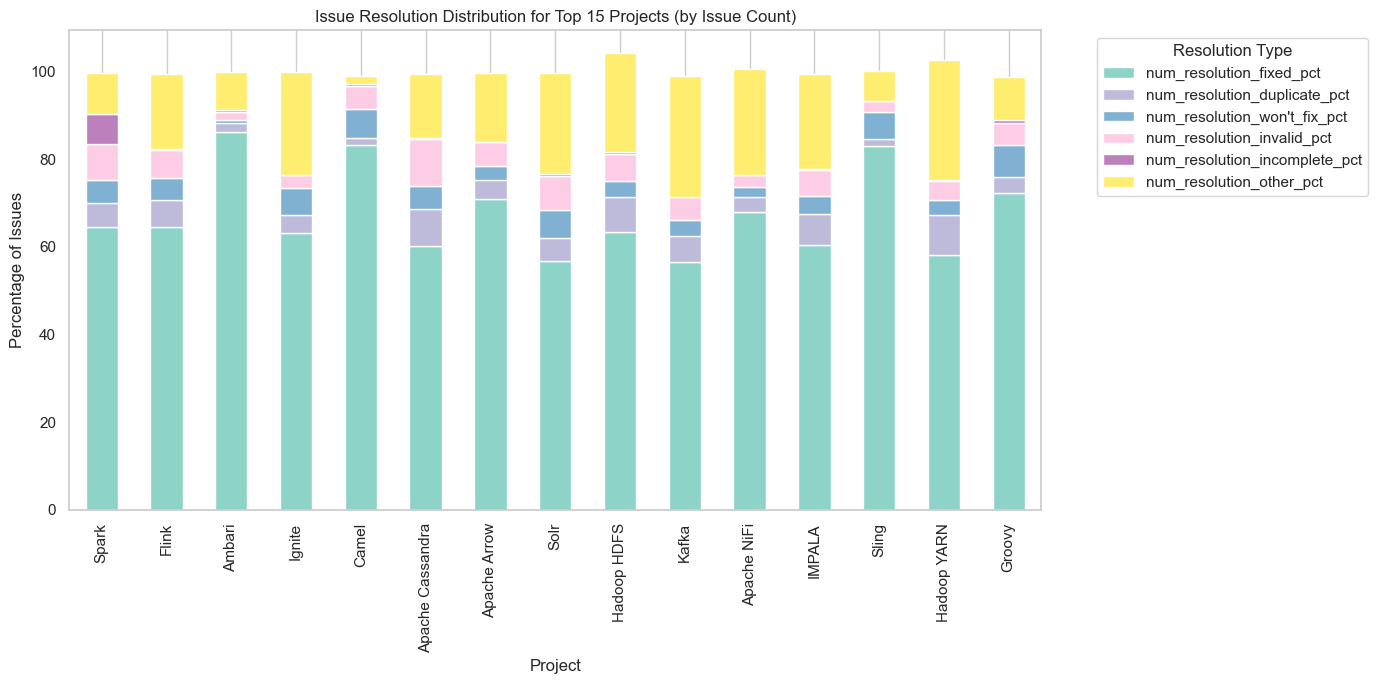

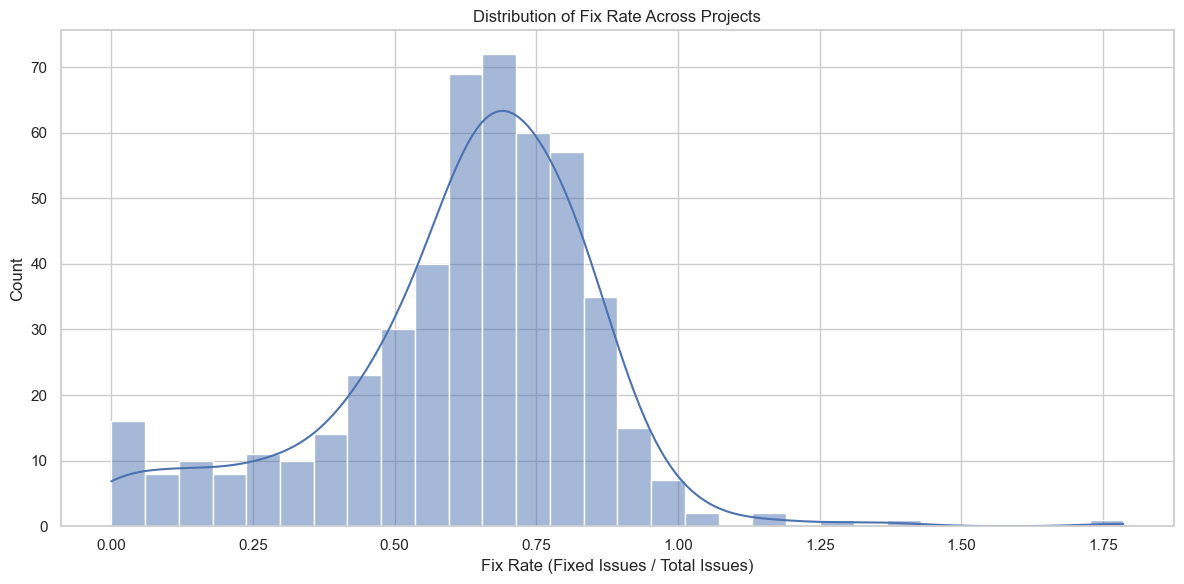

In [59]:
# Analyze issue resolution patterns
resolution_cols = [
    'num_resolution_fixed', 'num_resolution_duplicate', 'num_resolution_won\'t_fix',
    'num_resolution_invalid', 'num_resolution_incomplete', 'num_resolution_other'
]

# Calculate percentages
for col in resolution_cols:
    if col in df.columns:
        df[f"{col}_pct"] = (df[col] / df['total_issues']) * 100
        top15[f"{col}_pct"] = (top15[col] / top15['total_issues']) * 100

# Calculate total resolved issues
df["resolved_issues"] = df[resolution_cols].sum(axis=1)
df["resolution_ratio"] = df["resolved_issues"] / df["total_issues"]

# Plot distribution of resolution ratio
plt.figure(figsize=(12, 6))
sns.histplot(df['resolution_ratio'], bins=30, kde=True)
plt.title('Distribution of Resolution Ratio Across Projects')
plt.xlabel('Resolution Ratio (Resolved Issues / Total Issues)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot resolution breakdown for top 15 projects
resolution_pct_cols = [col for col in df.columns if '_pct' in col and 'resolution' in col]
resolution_df = top15[['project_name'] + resolution_pct_cols].set_index('project_name')

resolution_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 7),
    cmap='Set3'
)
plt.title('Issue Resolution Distribution for Top 15 Projects (by Issue Count)')
plt.xlabel('Project')
plt.ylabel('Percentage of Issues')
plt.legend(title='Resolution Type', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Calculate "Fix Rate" - proportion of issues marked as "fixed"
df["fix_rate"] = df["num_resolution_fixed"] / df["total_issues"]

# Visualize fix rate distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['fix_rate'], bins=30, kde=True)
plt.title('Distribution of Fix Rate Across Projects')
plt.xlabel('Fix Rate (Fixed Issues / Total Issues)')
plt.grid(True)
plt.tight_layout()
plt.show()

<a id="section5"></a>
## 5. Change Activity and Volatility

In this section, we'll analyze the volatility and change patterns in issues, which are indicators of project instability and potential risks.

Change Activity Metrics Summary:
                                     count     mean      std    min     25%  \
average_change_density            492.0000 230.2812 503.8818 0.0000 16.7490   
total_reopened                    492.0000  69.0874 183.6750 0.0000  0.0000   
average_author_churn              492.0000   0.6923   0.2182 0.0000  0.6246   
average_status_change_rate        492.0000   0.1684   0.0949 0.0000  0.1000   
average_resolution_change_rate    492.0000   0.1222   0.0722 0.0000  0.0727   
average_fix_version_change_rate   492.0000   0.0699   0.0637 0.0000  0.0207   
average_reassignment_rate         492.0000   0.0515   0.0509 0.0000  0.0269   
average_description_edit_rate     492.0000   0.0251   0.0383 0.0000  0.0078   
average_issue_type_change_rate    492.0000   0.0059   0.0185 0.0000  0.0000   
average_priority_change_rate      492.0000   0.0049   0.0098 0.0000  0.0000   
average_time_estimate_change_rate 492.0000   0.0023   0.0060 0.0000  0.0000   

                  

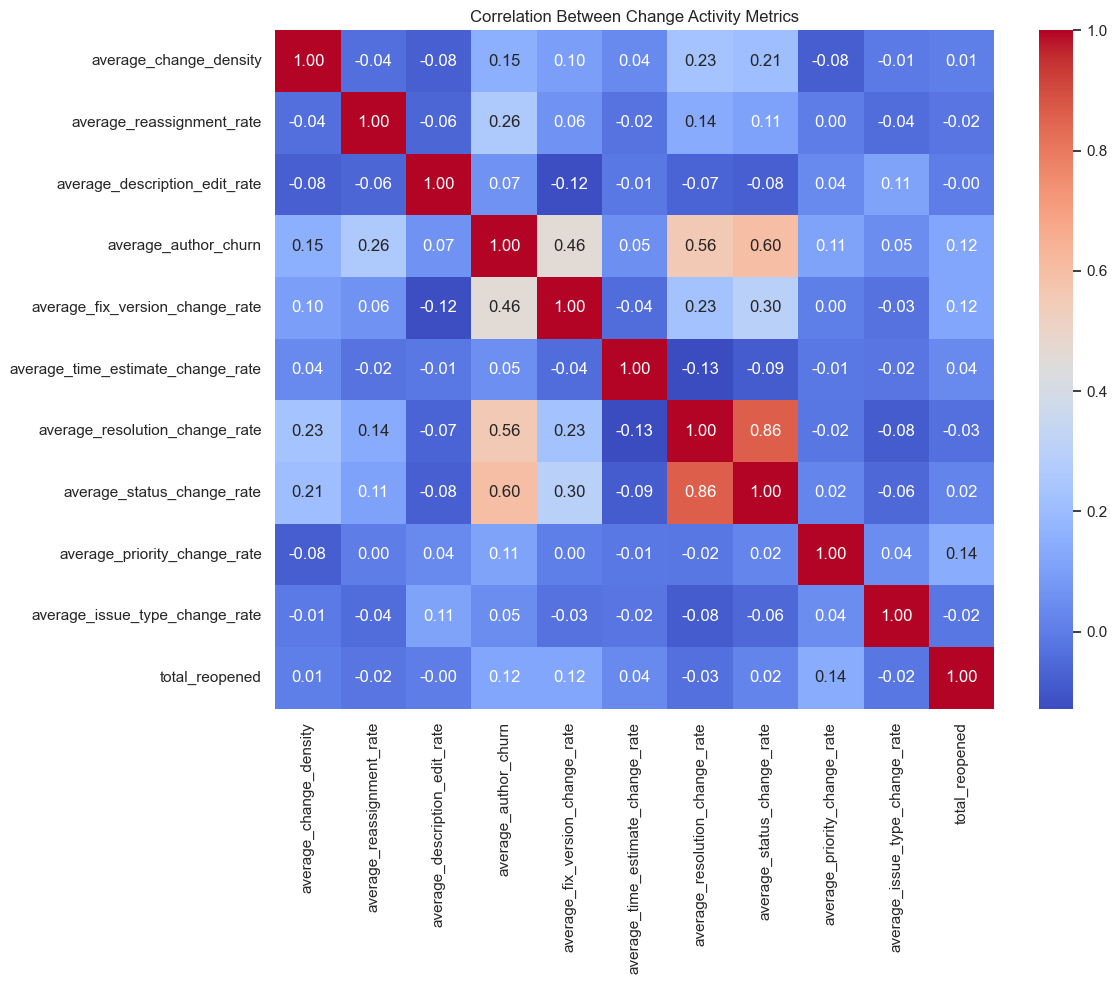

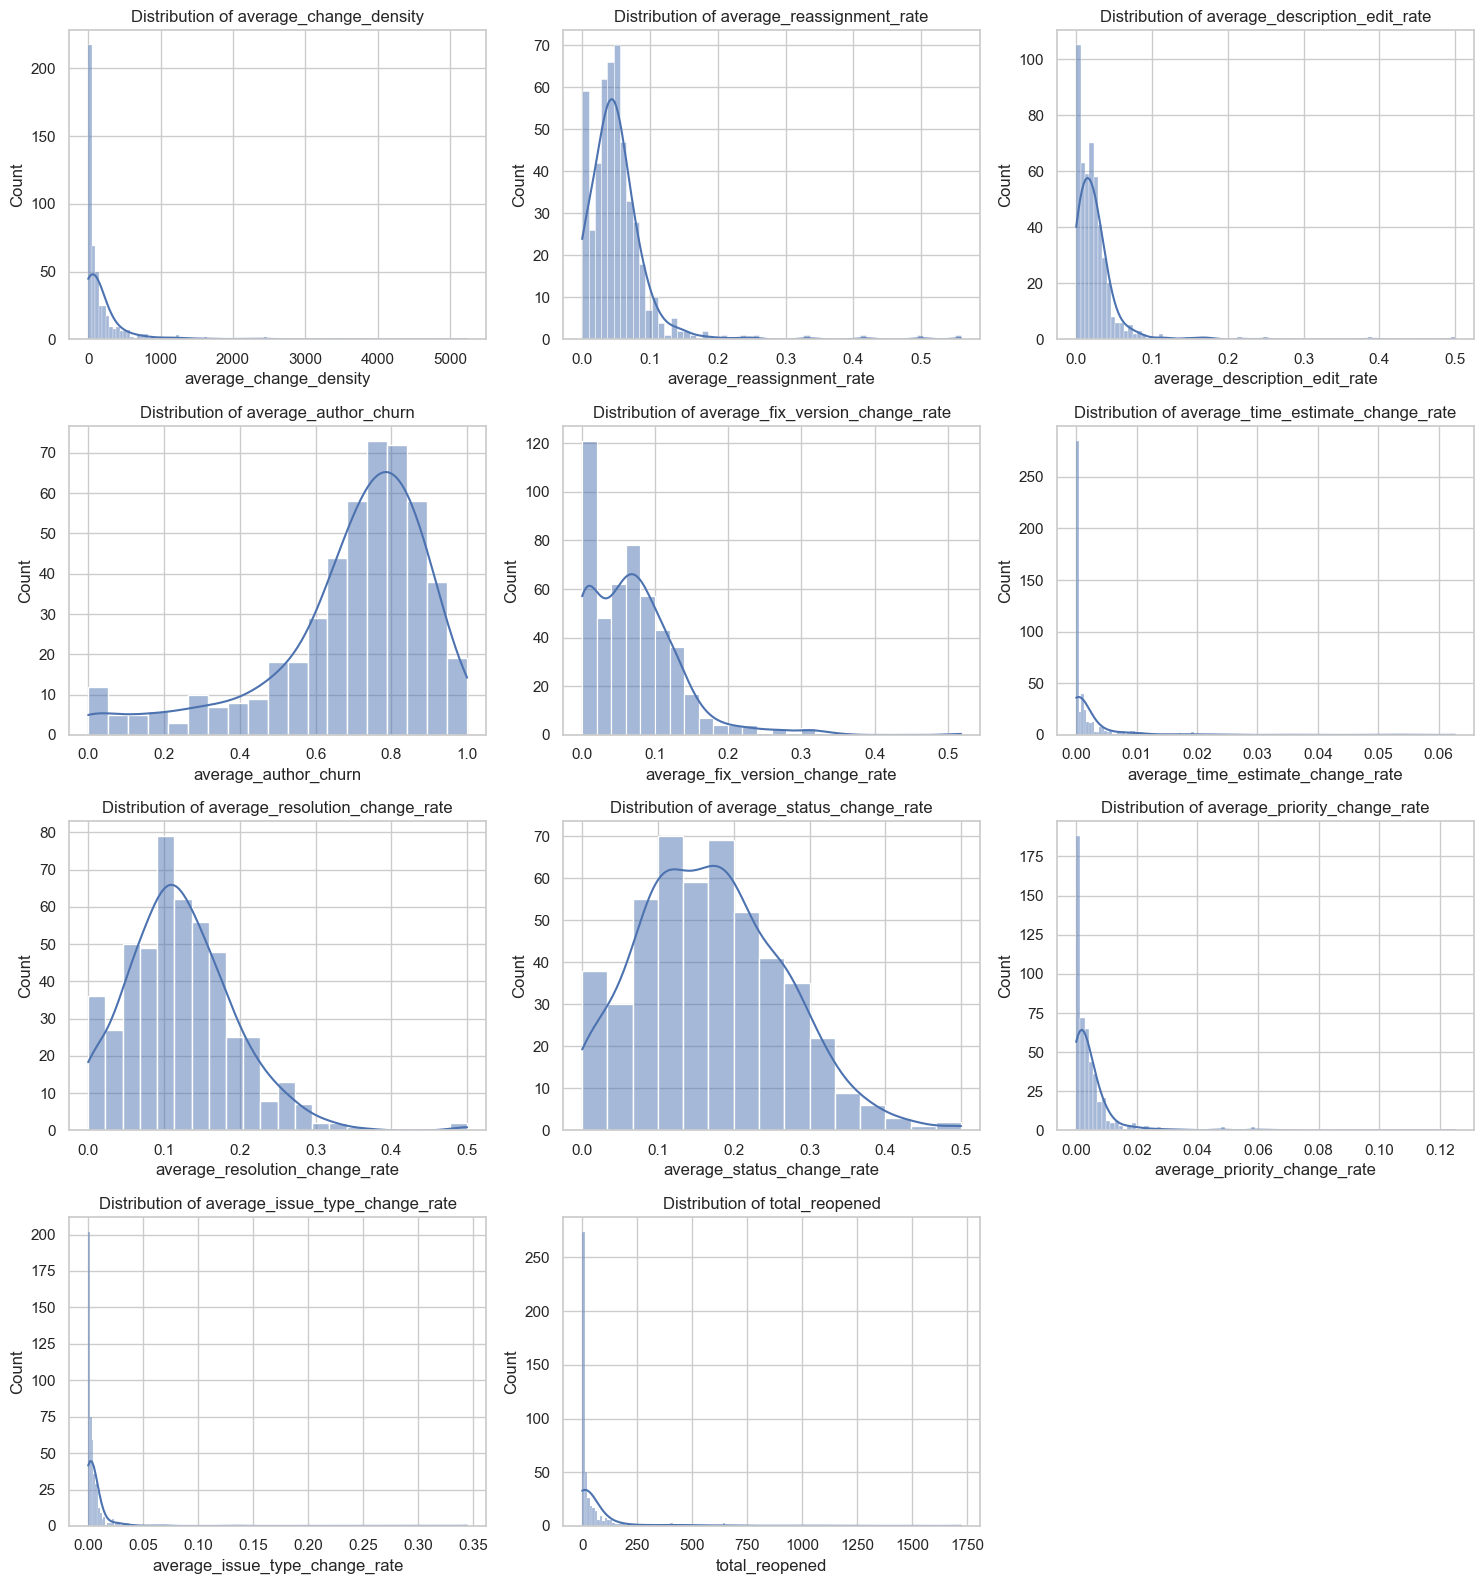

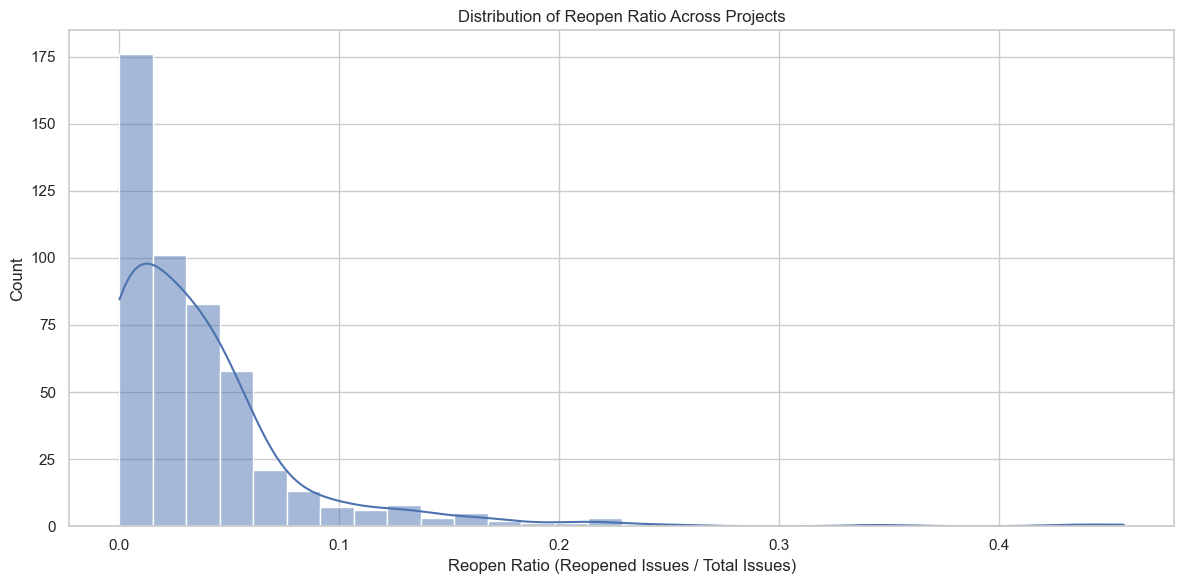

In [60]:
# Define volatility and change-related features
change_cols = [
    'average_change_density', 'average_reassignment_rate',
    'average_description_edit_rate', 'average_author_churn',
    'average_fix_version_change_rate', 'average_time_estimate_change_rate',
    'average_resolution_change_rate', 'average_status_change_rate',
    'average_priority_change_rate', 'average_issue_type_change_rate',
    'total_reopened'
]

# Filter to include only columns that exist in our dataframe
change_cols = [col for col in change_cols if col in df.columns]

# Calculate summary statistics
change_summary = df[change_cols].describe().T.sort_values(by='mean', ascending=False)
print("Change Activity Metrics Summary:")
print(change_summary)

# Create a correlation matrix for change features
plt.figure(figsize=(12, 10))
change_corr = df[change_cols].corr()
sns.heatmap(change_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Change Activity Metrics')
plt.tight_layout()
plt.show()

# Log-transform heavily skewed features if needed
for col in change_cols:
    if df[col].skew() > 1.5:  # High positive skew
        df[f"log1p_{col}"] = np.log1p(df[col])

# Create histograms for change metrics
n_cols = 3
n_rows = (len(change_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(change_cols):
    if i < len(axes):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].grid(True)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Calculate reopen ratio
df['reopen_ratio'] = df['total_reopened'] / df['total_issues']

plt.figure(figsize=(12, 6))
sns.histplot(df['reopen_ratio'], bins=30, kde=True)
plt.title('Distribution of Reopen Ratio Across Projects')
plt.xlabel('Reopen Ratio (Reopened Issues / Total Issues)')
plt.grid(True)
plt.tight_layout()
plt.show()

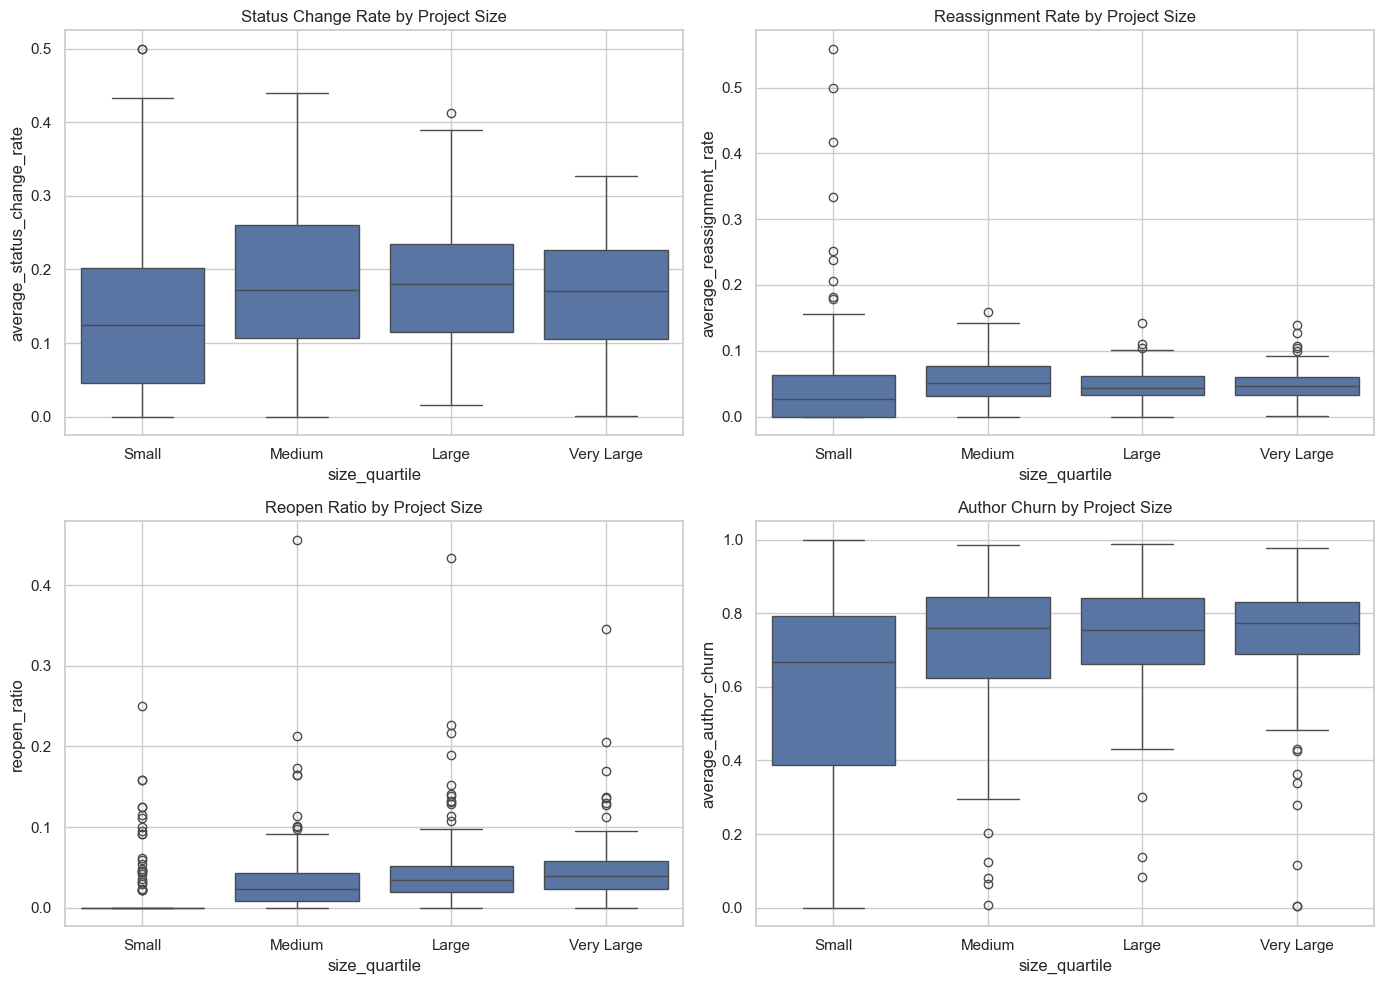

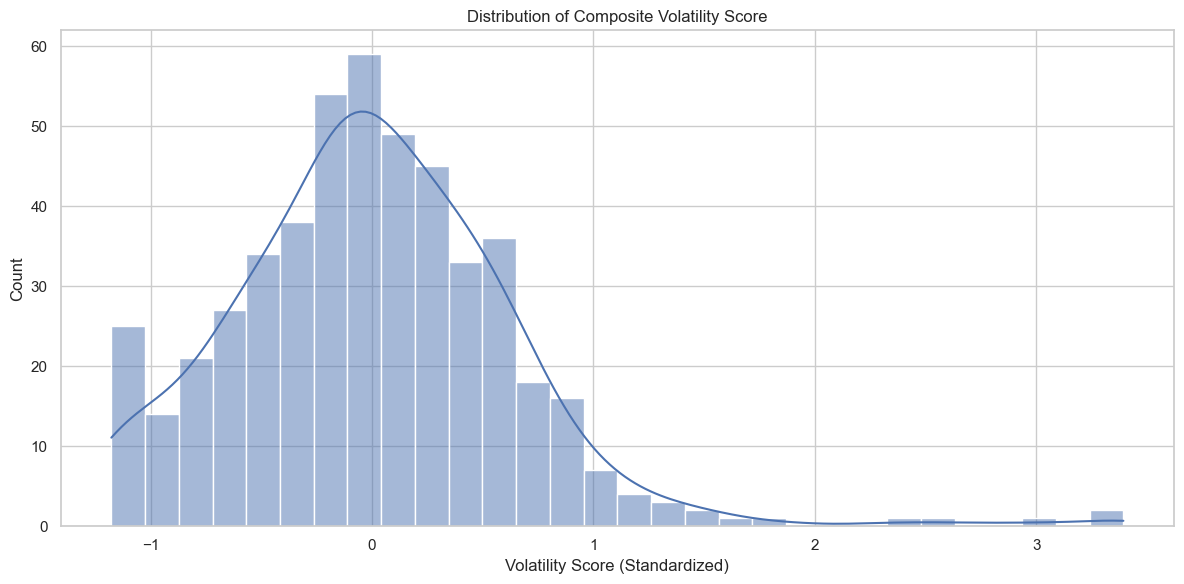

In [61]:
# Analyze relationship between project size and volatility
# Group projects by size quartiles
df['size_quartile'] = pd.qcut(df['total_issues'], 4, labels=['Small', 'Medium', 'Large', 'Very Large'])

# Visualize key volatility metrics across size groups
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='size_quartile', y='average_status_change_rate', data=df)
plt.title('Status Change Rate by Project Size')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.boxplot(x='size_quartile', y='average_reassignment_rate', data=df)
plt.title('Reassignment Rate by Project Size')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.boxplot(x='size_quartile', y='reopen_ratio', data=df)
plt.title('Reopen Ratio by Project Size')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.boxplot(x='size_quartile', y='average_author_churn', data=df)
plt.title('Author Churn by Project Size')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate composite volatility score
volatility_components = [
    'average_status_change_rate',
    'average_reassignment_rate',
    'reopen_ratio'
]
volatility_components = [col for col in volatility_components if col in df.columns]

# Standardize and average for a composite score
if len(volatility_components) > 0:
    scaler = StandardScaler()
    df_volatility = df[volatility_components].copy()
    # Handle NaN values by filling with column means
    df_volatility = df_volatility.fillna(df_volatility.mean())
    volatility_scaled = scaler.fit_transform(df_volatility)
    df['volatility_score'] = volatility_scaled.mean(axis=1)
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['volatility_score'], bins=30, kde=True)
    plt.title('Distribution of Composite Volatility Score')
    plt.xlabel('Volatility Score (Standardized)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<a id="section6"></a>
## 6. Issue Priority and Type Analysis

Now let's examine issue priorities and types, which can be indicators of both schedule and quality risks.

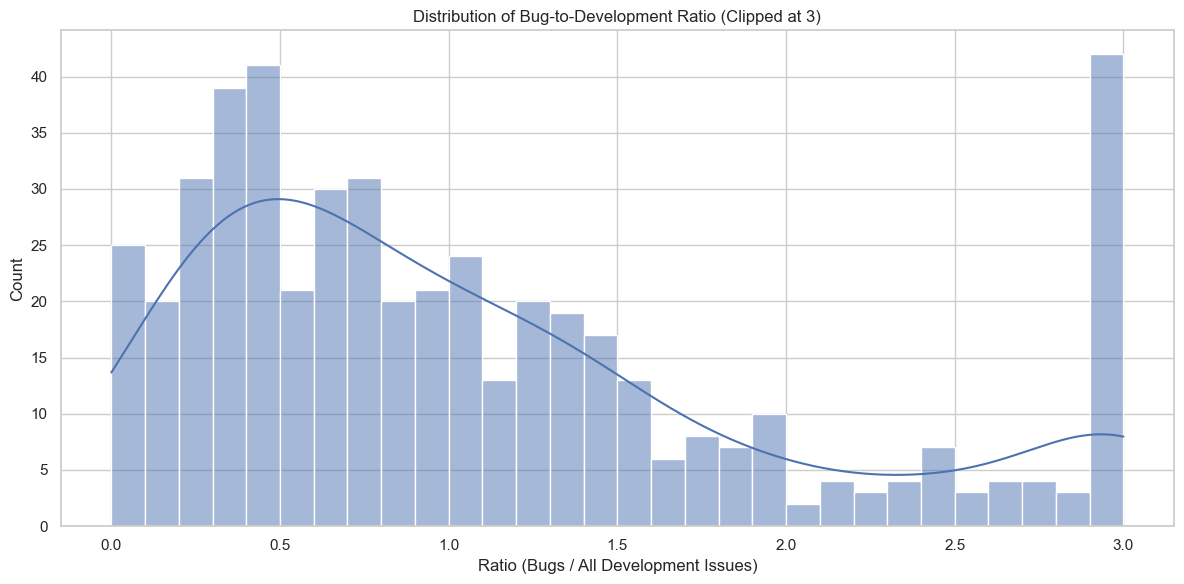

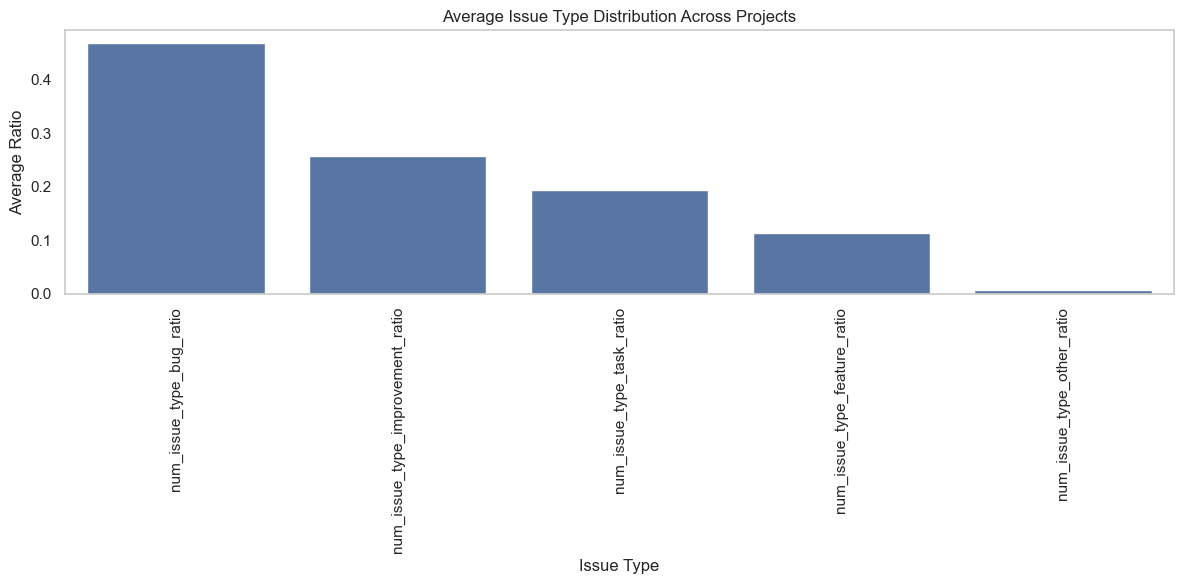

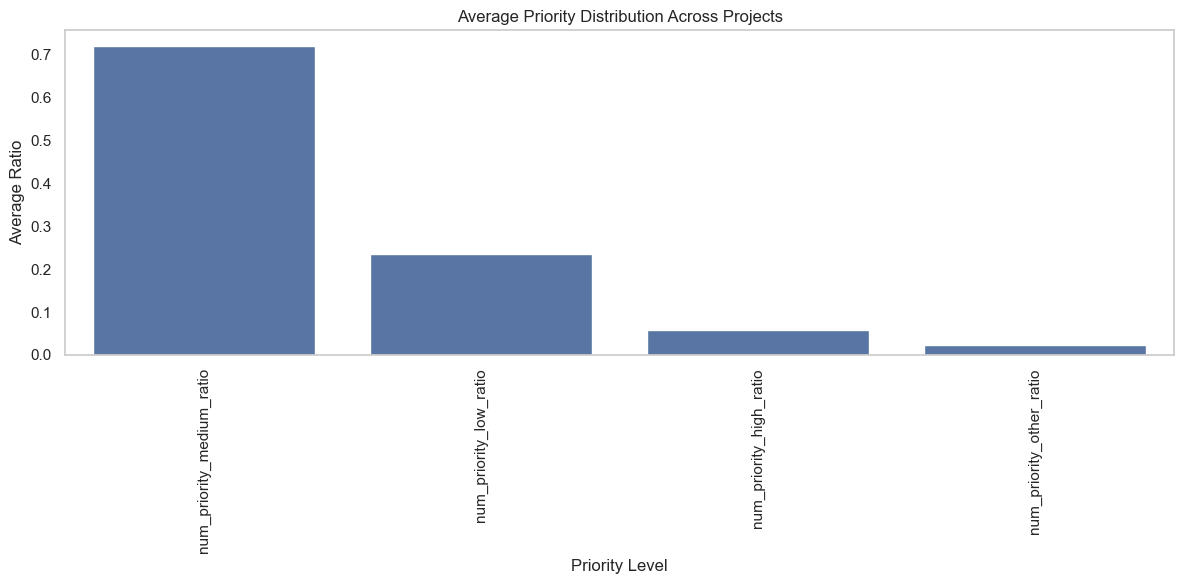

In [62]:
# Analyze issue types
type_cols = ['num_issue_type_bug', 'num_issue_type_feature', 'num_issue_type_improvement',
            'num_issue_type_task', 'num_issue_type_other']
type_cols = [col for col in type_cols if col in df.columns]

# Calculate proportions
for col in type_cols:
    df[f"{col}_ratio"] = df[col] / df['total_issues']

# Calculate bug-to-development ratio (bugs vs. all development work: features, improvements, tasks)
development_cols = ['num_issue_type_feature', 'num_issue_type_improvement', 'num_issue_type_task']
available_dev_cols = [col for col in development_cols if col in df.columns]

if 'num_issue_type_bug' in df.columns and len(available_dev_cols) > 0:
    # Sum all development work issues
    df['total_development_issues'] = df[available_dev_cols].sum(axis=1)
    # Calculate the ratio
    df['bug_to_development_ratio'] = df['num_issue_type_bug'] / (df['total_development_issues'] + 1e-5)
    
    # Visualize the distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df['bug_to_development_ratio'].clip(0, 3), bins=30, kde=True)
    plt.title('Distribution of Bug-to-Development Ratio (Clipped at 3)')
    plt.xlabel('Ratio (Bugs / All Development Issues)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Bug or development type columns not found.")

# Plot average issue type distribution
type_ratio_cols = [col for col in df.columns if '_ratio' in col and 'issue_type' in col]
if type_ratio_cols:
    type_ratios_avg = df[type_ratio_cols].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=type_ratios_avg.index, y=type_ratios_avg.values)
    plt.title('Average Issue Type Distribution Across Projects')
    plt.xlabel('Issue Type')
    plt.ylabel('Average Ratio')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Analyze issue priorities
priority_cols = ['num_priority_high', 'num_priority_medium', 'num_priority_low', 'num_priority_other']
priority_cols = [col for col in priority_cols if col in df.columns]

# Calculate proportions
for col in priority_cols:
    df[f"{col}_ratio"] = df[col] / df['total_issues']

# Plot average priority distribution
priority_ratio_cols = [col for col in df.columns if '_ratio' in col and 'priority' in col]
if priority_ratio_cols:
    priority_ratios_avg = df[priority_ratio_cols].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=priority_ratios_avg.index, y=priority_ratios_avg.values)
    plt.title('Average Priority Distribution Across Projects')
    plt.xlabel('Priority Level')
    plt.ylabel('Average Ratio')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

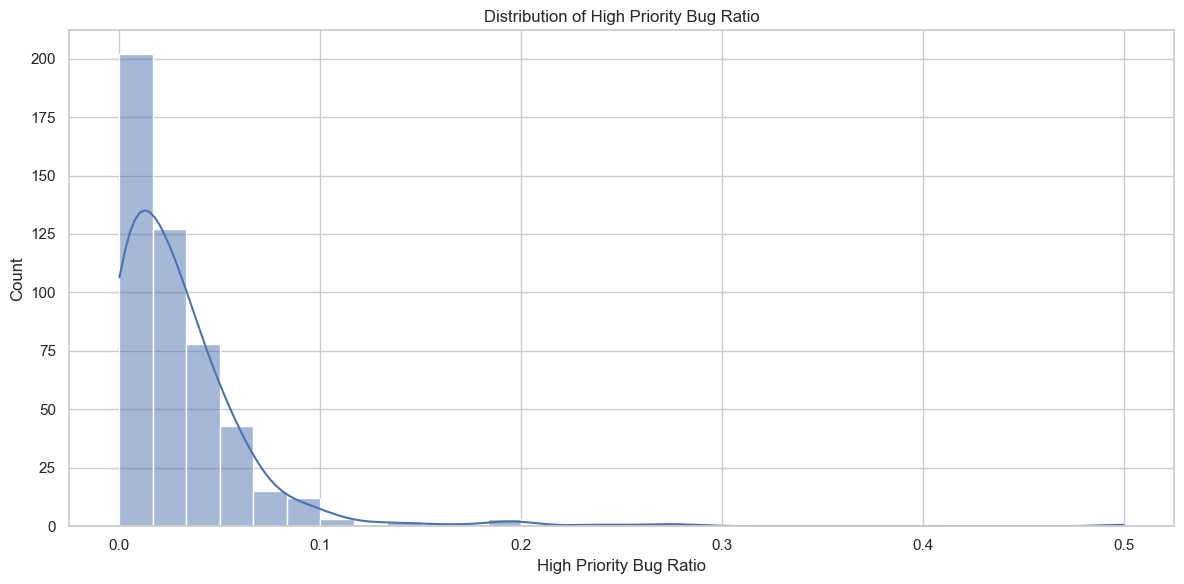

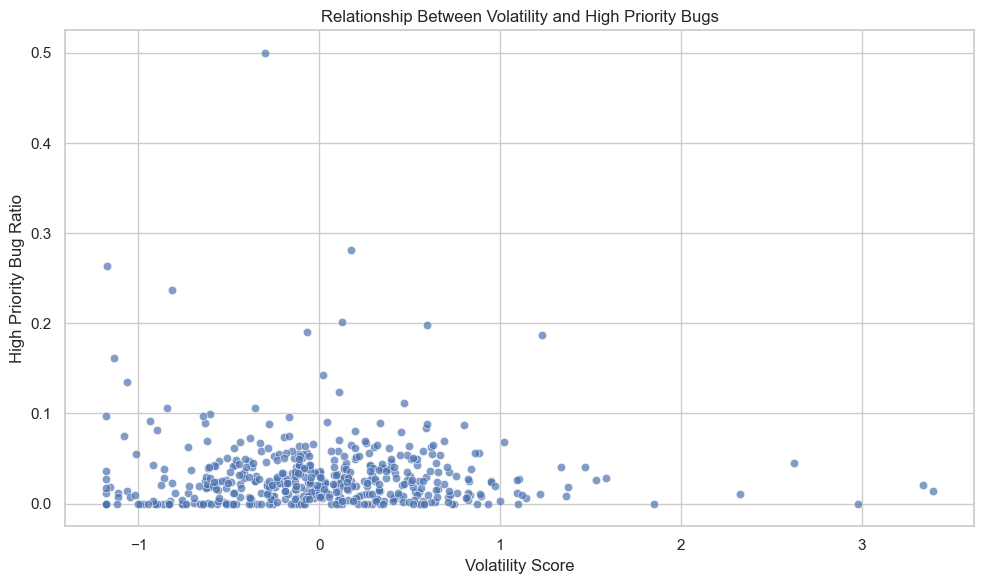

In [63]:
# Analyze high-priority bugs specifically
if 'num_issue_type_bug' in df.columns and 'num_priority_high' in df.columns:
    # Estimate high-priority bugs (exact column may not exist)
    df['num_high_priority_bugs'] = df['num_issue_type_bug'] * df['num_priority_high_ratio']
    df['high_priority_bug_ratio'] = df['num_high_priority_bugs'] / df['total_issues']
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['high_priority_bug_ratio'], bins=30, kde=True)
    plt.title('Distribution of High Priority Bug Ratio')
    plt.xlabel('High Priority Bug Ratio')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Examine relationship between high-priority bugs and volatility
    if 'volatility_score' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=df, 
            x='volatility_score', 
            y='high_priority_bug_ratio',
            alpha=0.7
        )
        plt.title('Relationship Between Volatility and High Priority Bugs')
        plt.xlabel('Volatility Score')
        plt.ylabel('High Priority Bug Ratio')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("Bug or priority columns not found.")

<a id="section7"></a>
## 7. Schedule Risk Label Development

In this section, we'll develop a label for schedule risk based on multiple indicators like issue lifespan, status changes, churn, and incomplete issues.

In [64]:
df_risk_labels = pd.read_csv("./apache/train_project_risk_labels.csv")
df = df.merge(df_risk_labels, on='project_id', how='left')


Schedule Risk Distribution (Denoised Labels):
schedule_risk
0   0.6992
1   0.3008
Name: proportion, dtype: float64

Schedule Risk Distribution (Majority Vote):
schedule_risk_majority_vote
0   0.6992
1   0.3008
Name: proportion, dtype: float64


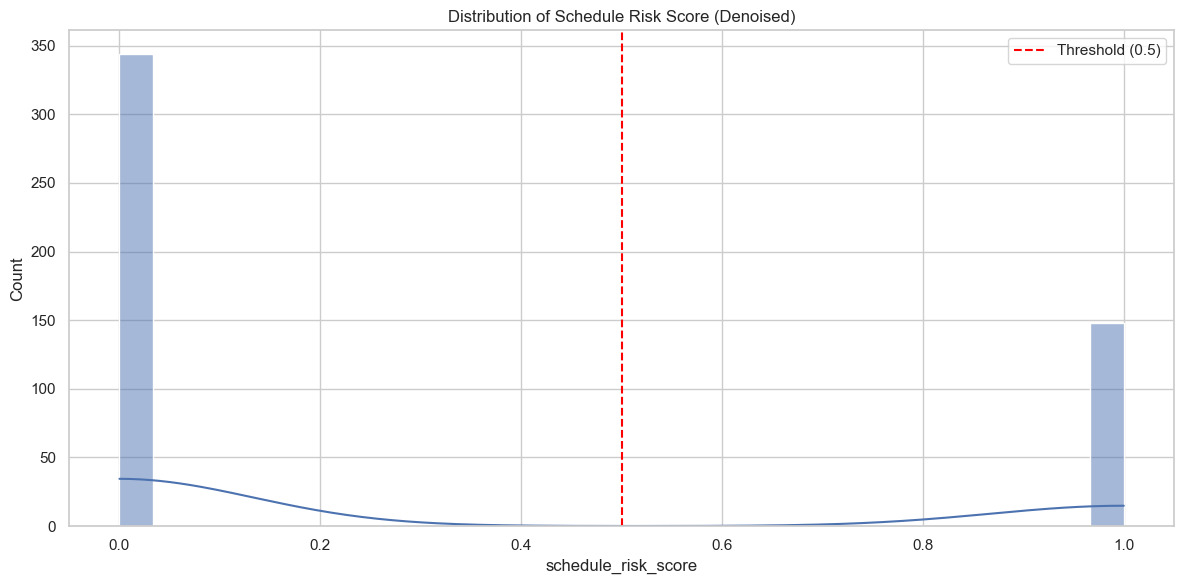

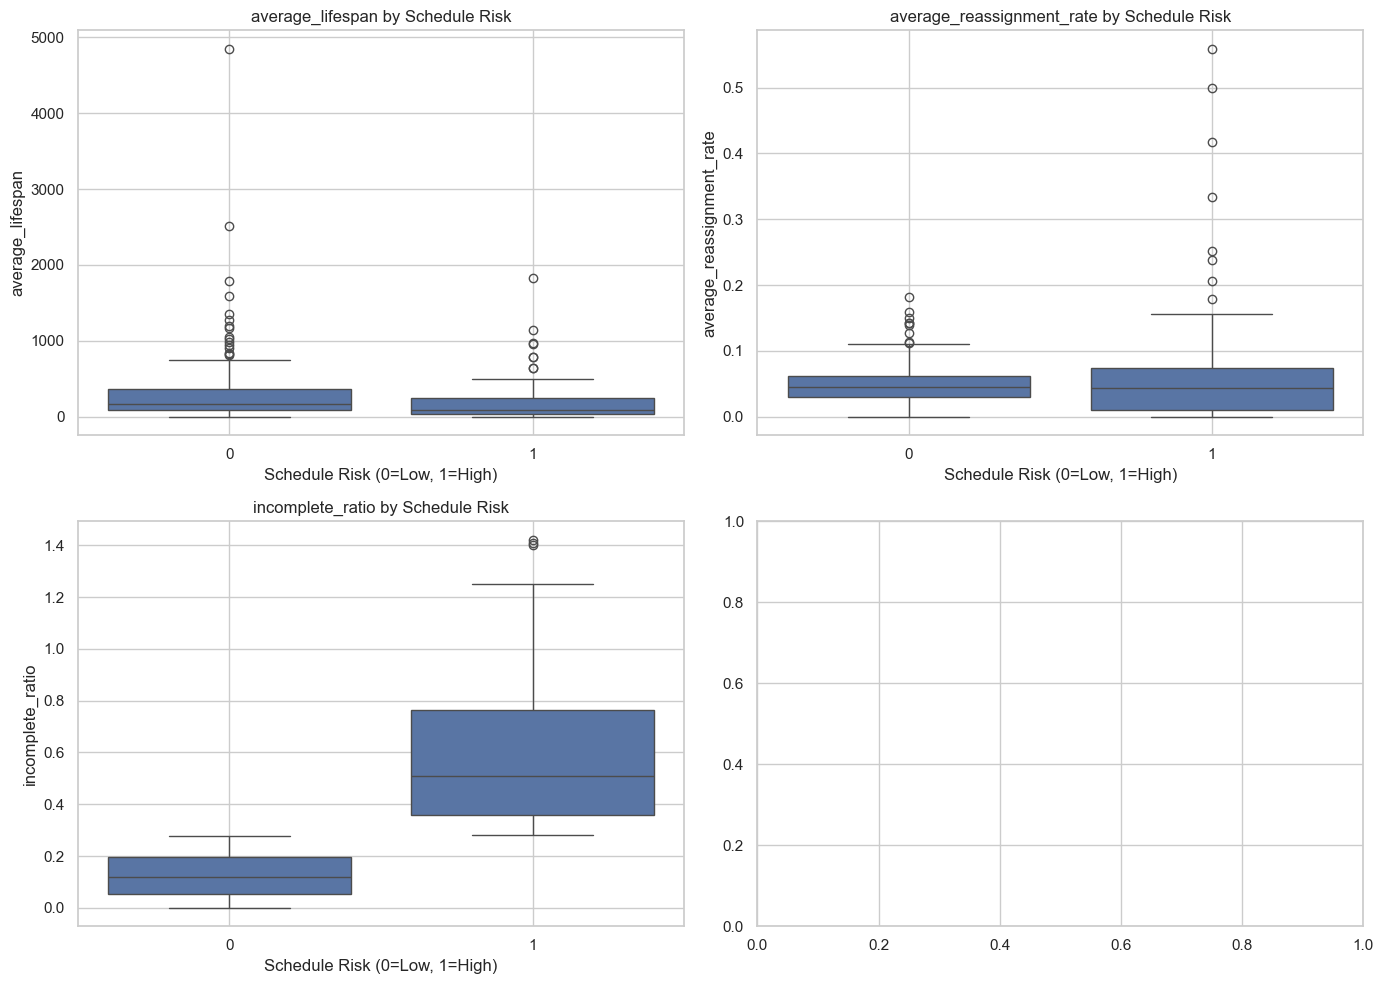

<Figure size 1200x800 with 0 Axes>

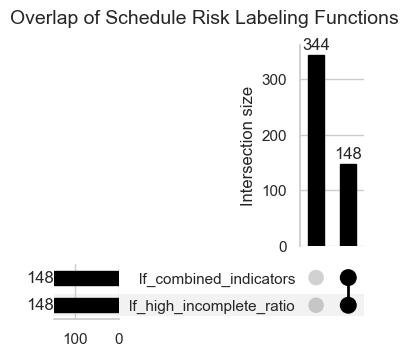

In [65]:
# Define schedule risk indicators (features)
schedule_risk_indicators = [
    'average_lifespan',
    'average_reassignment_rate', 
    'incomplete_ratio',
]

# Display the risk distribution
print("\nSchedule Risk Distribution (Denoised Labels):")
print(df['schedule_risk'].value_counts(normalize=True))

print("\nSchedule Risk Distribution (Majority Vote):")
print(df['schedule_risk_majority_vote'].value_counts(normalize=True))

threshold_composite = 0.5  # Default threshold for probabilities

# Visualize the distribution of the composite score from LabelModel
plt.figure(figsize=(12, 6))
sns.histplot(df['schedule_risk_score'], bins=30, kde=True)
plt.axvline(threshold_composite, color='red', linestyle='--', 
           label=f'Threshold (0.5)')
plt.title('Distribution of Schedule Risk Score (Denoised)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the relationship between the indicators and the risk
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(schedule_risk_indicators):
    if i < len(axes):
        sns.boxplot(x='schedule_risk', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'{col} by Schedule Risk')
        axes[i].set_xlabel('Schedule Risk (0=Low, 1=High)')
        axes[i].grid(True)

plt.tight_layout()
plt.show()

df_lf_flags = pd.read_csv("./apache/schedule_risk_lf_flags.csv")

upset_data = from_indicators(df_lf_flags)

plt.figure(figsize=(12, 8))
upset_plot(
    upset_data,
    sort_by='cardinality',
    show_counts=True,
    subset_size='count'
)
plt.suptitle("Overlap of Schedule Risk Labeling Functions", fontsize=14)
plt.tight_layout()
plt.show()

<a id="section8"></a>
## 8. Quality Risk Label Development

Similar to the schedule risk, we'll now develop a label for quality risk based on indicators like bug rates, reopen rates, and fix rates.

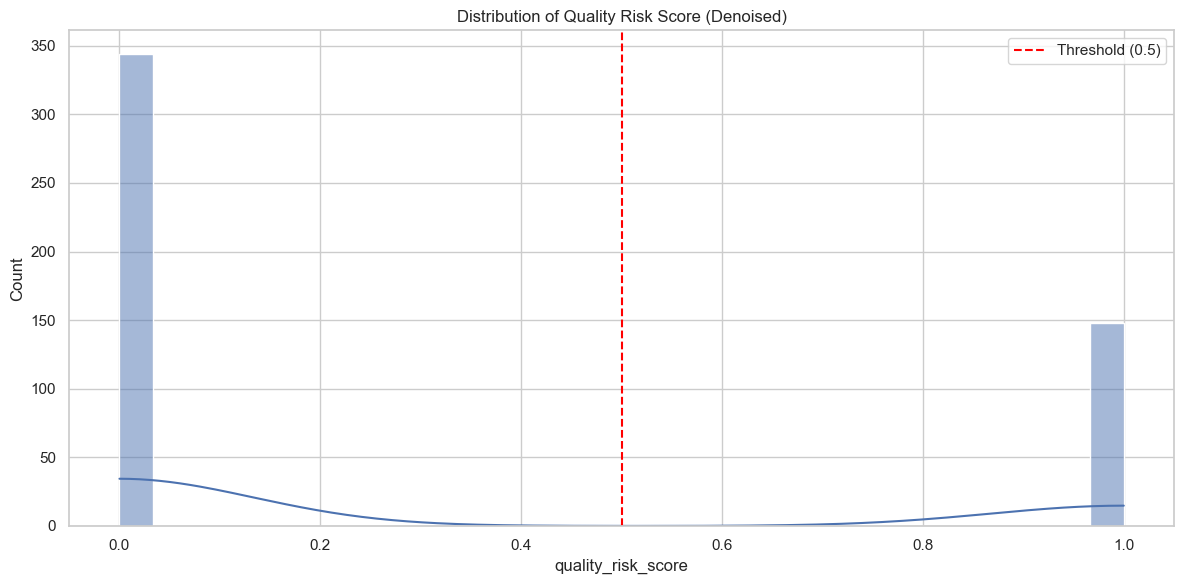

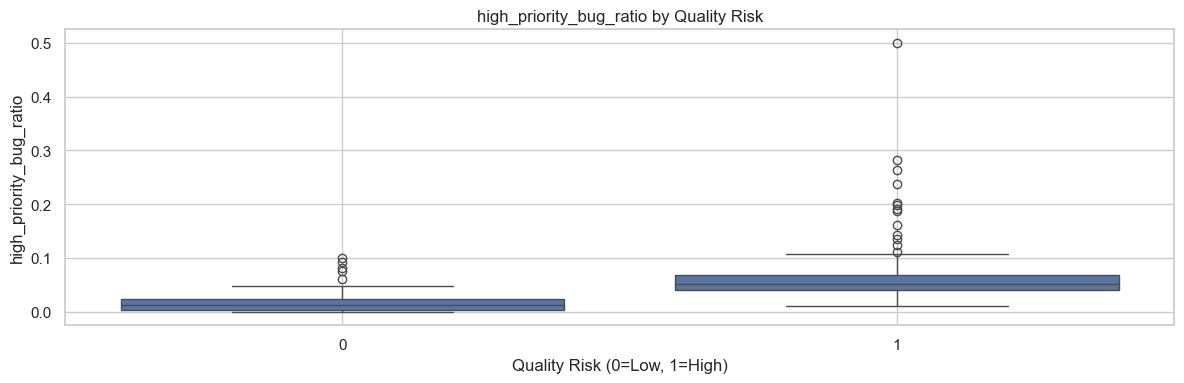

AttributeError: 'Index' object has no attribute 'levels'

<Figure size 1200x800 with 0 Axes>

In [66]:
# Define quality risk indicators
# df['inverse_fix_rate'] = 1 - df['fix_rate']
quality_risk_indicators = [
    # 'num_issue_type_bug_ratio',
    'high_priority_bug_ratio',
    # 'reopen_ratio',
    # 'bug_to_development_ratio',
    # 'inverse_fix_rate',
]


# Visualize the distribution of the composite score from LabelModel
plt.figure(figsize=(12, 6))
sns.histplot(df['quality_risk_score'], bins=30, kde=True)
plt.axvline(threshold_composite, color='red', linestyle='--', 
        label=f'Threshold (0.5)')
plt.title('Distribution of Quality Risk Score (Denoised)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the relationship between the indicators and the risk
n_cols = min(2, len(quality_risk_indicators))
n_rows = (len(quality_risk_indicators) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))

if n_rows * n_cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, col in enumerate(quality_risk_indicators):
    if i < len(axes):
        sns.boxplot(x='quality_risk', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'{col} by Quality Risk')
        axes[i].set_xlabel('Quality Risk (0=Low, 1=High)')
        axes[i].grid(True)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

df_lf_flags = pd.read_csv("./apache/quality_risk_lf_flags.csv")
upset_data = from_indicators(df_lf_flags)

plt.figure(figsize=(12, 8))
upset_plot(
    upset_data,
    sort_by='cardinality',
    show_counts=True,
    subset_size='count'
)
plt.suptitle("Overlap of Quality Risk Labeling Functions", fontsize=14)
plt.tight_layout()
plt.show()

<a id="section9"></a>
## 9. Conclusions and Combined Risk Analysis

Finally, let's analyze the relationship between schedule risk and quality risk, and export the final dataset with risk labels for future modeling.

Comparing Snorkel-generated risk labels:
Agreement between denoised and majority vote (Schedule Risk): 1.000
Agreement between denoised and majority vote (Quality Risk): 1.000

Risk Matrix (normalized):
Quality Risk       0      1
Schedule Risk              
0             0.4654 0.2337
1             0.2337 0.0671


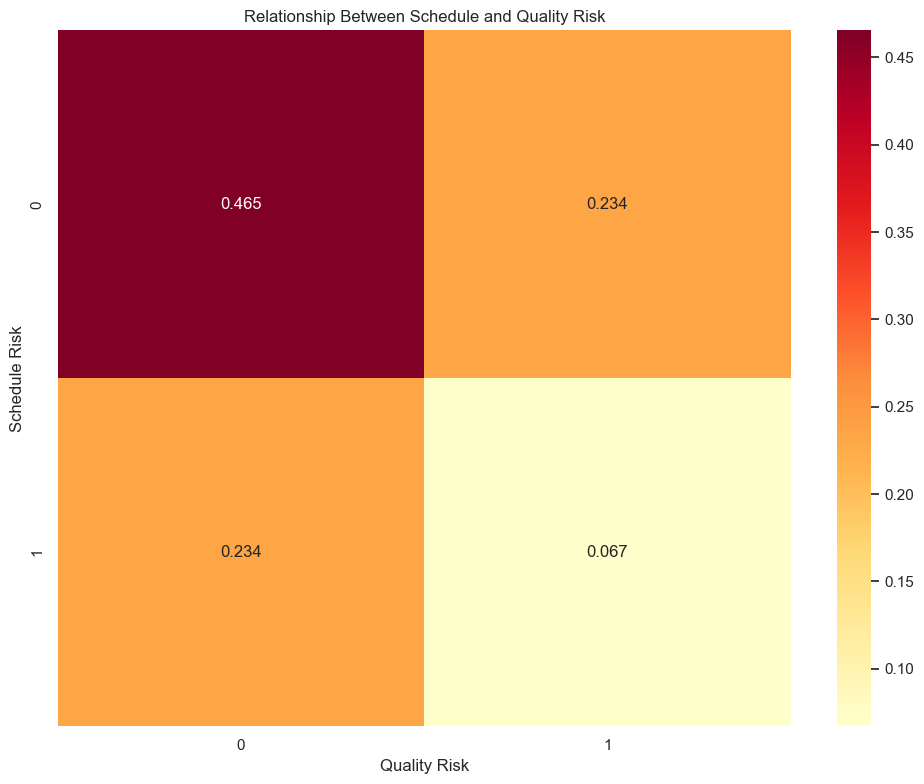

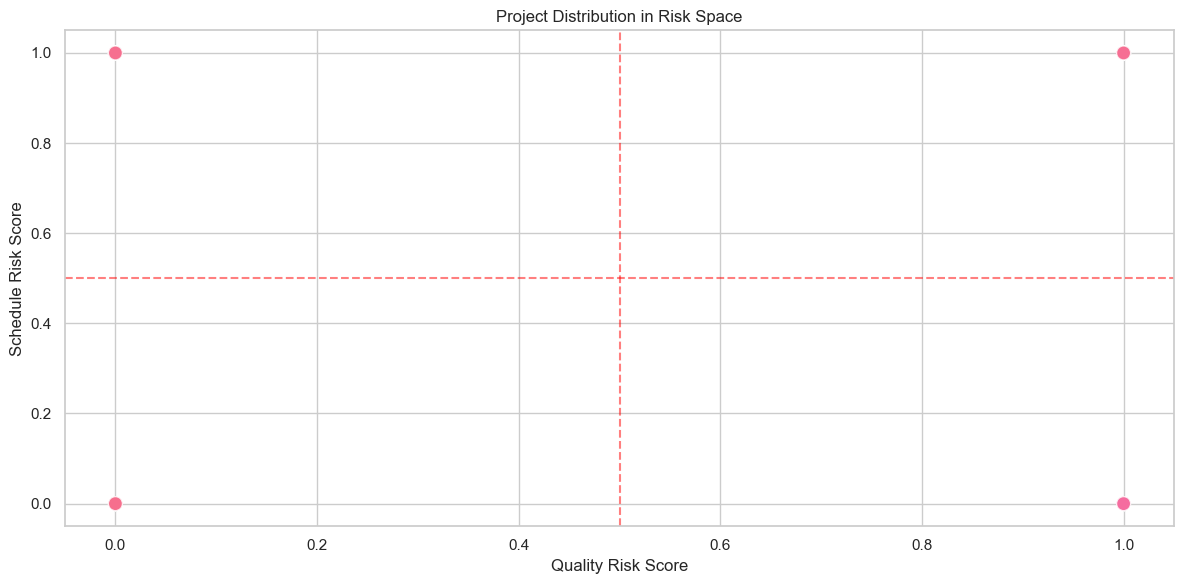

In [67]:
# Compare the effectiveness of Snorkel labeling
print("Comparing Snorkel-generated risk labels:")

# Check agreement between denoised and majority vote labels
schedule_agreement = (df['schedule_risk'] == df['schedule_risk_majority_vote']).mean()
quality_agreement = (df['quality_risk'] == df['quality_risk_majority_vote']).mean()

print(f"Agreement between denoised and majority vote (Schedule Risk): {schedule_agreement:.3f}")
print(f"Agreement between denoised and majority vote (Quality Risk): {quality_agreement:.3f}")

# Create a confusion matrix of schedule vs quality risk
risk_matrix = pd.crosstab(
    df['schedule_risk'], 
    df['quality_risk'], 
    normalize='all', 
    rownames=['Schedule Risk'], 
    colnames=['Quality Risk']
)

print("\nRisk Matrix (normalized):")
print(risk_matrix)

# Visualize the relationship between the two types of risk
plt.figure(figsize=(10, 8))
sns.heatmap(risk_matrix, annot=True, cmap='YlOrRd', fmt='.3f', cbar=True)
plt.title('Relationship Between Schedule and Quality Risk')
plt.tight_layout()
plt.show()

# Evaluate how well Snorkel's probabilistic labels separate the projects
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    data=df,
    x='quality_risk_score',
    y='schedule_risk_score',
    hue='project_name',  # Color by project
    alpha=0.7,
    s=100,
    legend=False  # Disable legend
)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
plt.title('Project Distribution in Risk Space')
plt.xlabel('Quality Risk Score')
plt.ylabel('Schedule Risk Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# # Save the labeled dataset for future modeling
# df.to_csv('./apache/project_risk_labels.csv', index=False)
# print("\nLabeled dataset saved to './apache/project_risk_labels.csv'")

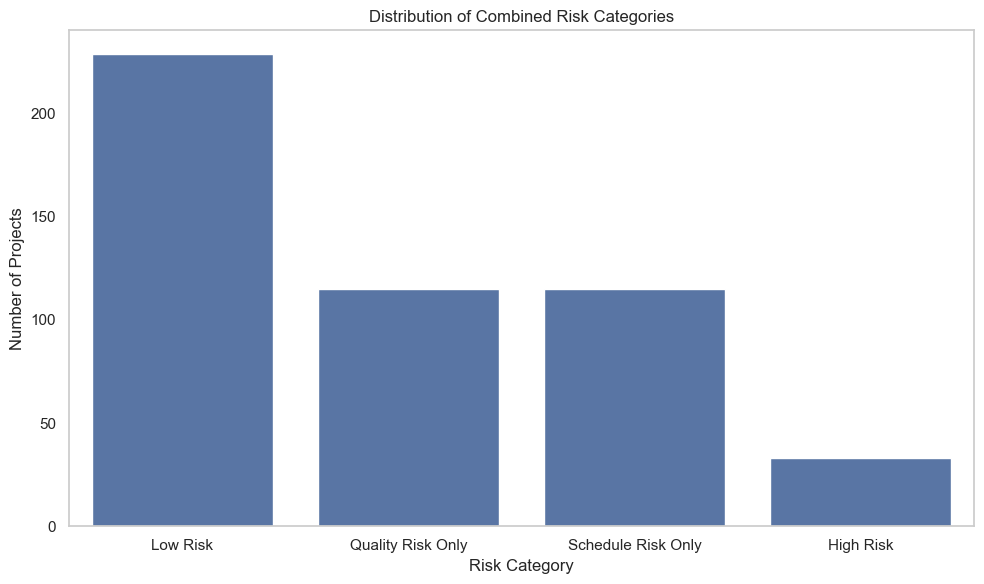

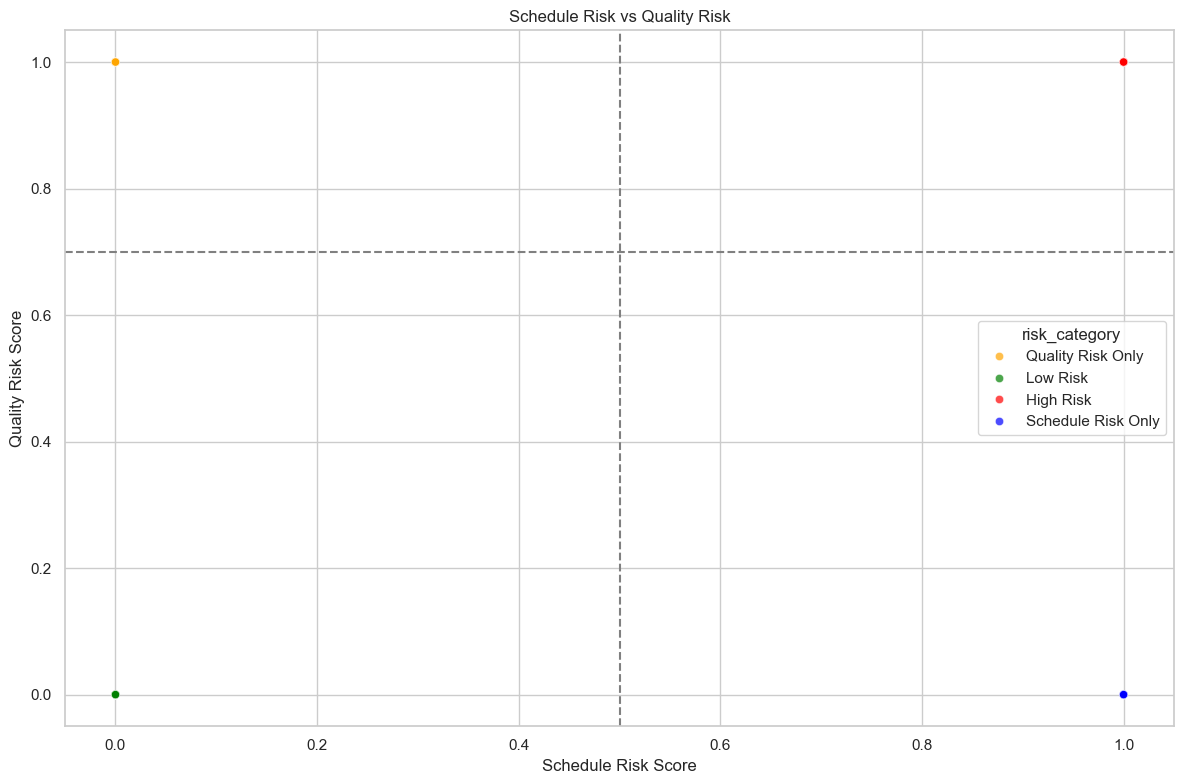

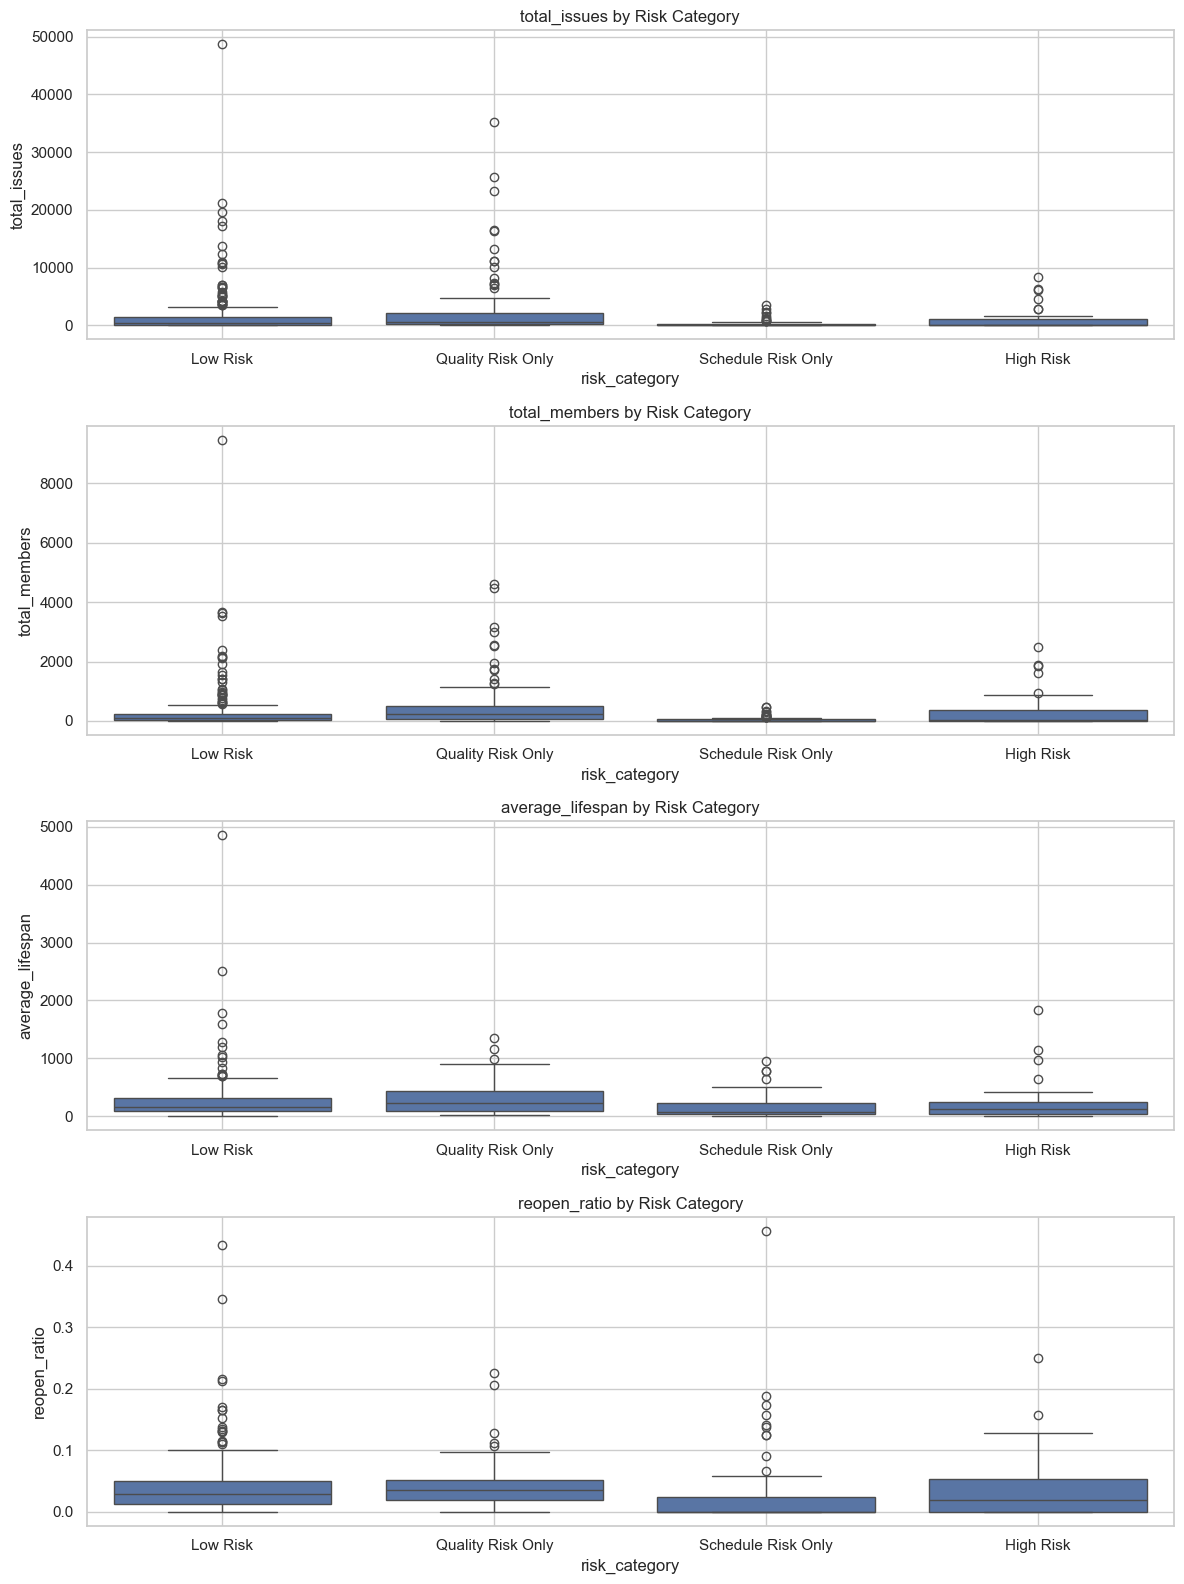

<Figure size 1400x800 with 0 Axes>

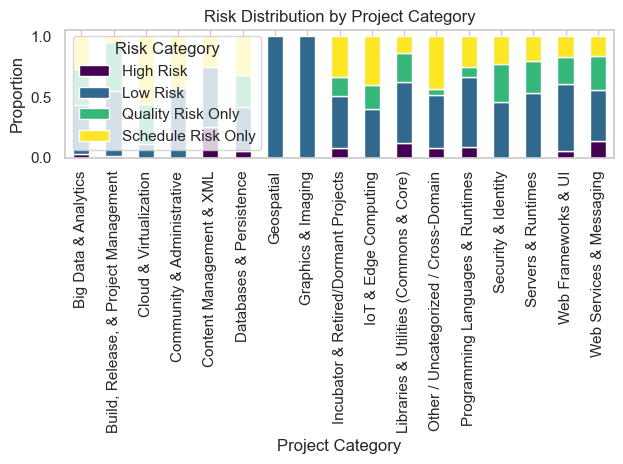

In [68]:
quantile_threshold = 0.7 # as used in the Snorkel labeling functions
    
# Plot risk distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='risk_category', 
                order=['Low Risk', 'Quality Risk Only', 'Schedule Risk Only', 'High Risk'])
plt.title('Distribution of Combined Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Number of Projects')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Scatter plot of schedule risk score vs quality risk score
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='schedule_risk_score', 
    y='quality_risk_score',
    hue='risk_category',
    palette={'Low Risk': 'green', 'Quality Risk Only': 'orange', 
                'Schedule Risk Only': 'blue', 'High Risk': 'red'},
    alpha=0.7
)
plt.axvline(threshold_composite, color='gray', linestyle='--')
plt.axhline(df['quality_risk_score'].quantile(quantile_threshold), color='gray', linestyle='--')
plt.title('Schedule Risk vs Quality Risk')
plt.xlabel('Schedule Risk Score')
plt.ylabel('Quality Risk Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare risk categories by project metrics
comparison_cols = ['total_issues', 'total_members', 'average_lifespan', 'reopen_ratio']
comparison_cols = [col for col in comparison_cols if col in df.columns]

if comparison_cols:
    fig, axes = plt.subplots(len(comparison_cols), 1, figsize=(12, 4*len(comparison_cols)))
    if len(comparison_cols) == 1:
        axes = [axes]
        
    for i, col in enumerate(comparison_cols):
        sns.boxplot(
            data=df, 
            x='risk_category', 
            y=col,
            order=['Low Risk', 'Quality Risk Only', 'Schedule Risk Only', 'High Risk'],
            ax=axes[i]
        )
        axes[i].set_title(f'{col} by Risk Category')
        axes[i].grid(True)
        
    plt.tight_layout()
    plt.show()
    
# Risk distribution by project category
risk_by_category = pd.crosstab(
    df['project_category'], 
    df['risk_category'], 
    normalize='index'
)

plt.figure(figsize=(14, 8))
risk_by_category.plot(
    kind='bar', 
    stacked=True,
    colormap='viridis'
)
plt.title('Risk Distribution by Project Category')
plt.xlabel('Project Category')
plt.ylabel('Proportion')
plt.legend(title='Risk Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
df.columns.tolist()

['project_id',
 'project_key',
 'project_name',
 'project_category',
 'total_reopened',
 'average_lifespan',
 'average_workspan',
 'average_change_density',
 'average_reassignment_rate',
 'average_description_edit_rate',
 'average_author_churn',
 'average_fix_version_change_rate',
 'average_time_estimate_change_rate',
 'average_resolution_change_rate',
 'average_status_change_rate',
 'average_priority_change_rate',
 'average_issue_type_change_rate',
 'total_changes',
 'total_assignees',
 'total_reporters',
 'total_members',
 'total_issues',
 'num_resolution_duplicate',
 "num_resolution_won't_fix",
 'num_resolution_other',
 'num_resolution_fixed',
 'num_resolution_invalid',
 'num_resolution_incomplete',
 'num_resolution_auto_closed',
 'num_resolution_workaround',
 'num_resolution_feedback',
 'num_status_to_do',
 'num_status_in_progress',
 'num_status_other',
 'num_status_done',
 'num_priority_high',
 'num_priority_low',
 'num_priority_medium',
 'num_priority_other',
 'num_issue_type_oth

In [69]:
# Export the final dataset with risk labels
df.to_csv('./apache/train_labeled.csv', index=False)

In [70]:
# label the test set
from prep import preprocess_data

df_test = pd.read_csv("./apache/test.csv")

test_labels = pd.read_csv("./apache/test_project_risk_labels.csv")
df_test = df_test.merge(test_labels, on='project_id', how='left')

# Save the test set with risk labels
df_test.to_csv('./apache/test_labeled.csv', index=False)
print("\nLabeled test dataset saved to './apache/test_labeled.csv'")


Labeled test dataset saved to './apache/test_labeled.csv'


## Summary of Findings

Our comprehensive exploratory data analysis has revealed several key insights about software project risks:

1. **Project Metadata**:
   - Project sizes vary significantly across categories, with Big Data & Analytics projects generally having the largest issue volumes.
   - There's a strong correlation between total issues, members, and reporters, as expected.
   - The assignee-to-reporter ratio offers insights into team structure and helps identify projects with imbalanced task distribution.

2. **Issue Lifecycle**:
   - Average issue lifespan varies considerably across projects and categories.
   - Larger projects tend to have more structured processes but not necessarily faster issue resolution.
   - A significant portion of projects maintain high incomplete issue ratios, indicating potential schedule challenges.

3. **Change and Volatility**:
   - Issue volatility (reassignment, status changes, reopening) is a strong indicator of project instability.
   - There's notable correlation between different change metrics.
   - Project size appears to impact volatility patterns in complex ways.

4. **Issue Types and Priority**:
   - Bug ratios and high-priority bug rates vary across projects and categories.
   - Projects with higher bug-to-feature ratios often correlate with quality concerns.
   - Priority distribution offers insights into project management focus.

5. **Risk Labels**:
   - We've created robust schedule and quality risk labels based on multiple indicators.
   - Schedule risk is primarily driven by issue lifespan, status changes, and incomplete ratios.
   - Quality risk is associated with high-priority bugs, reopen rates, and fix rates.
   - Combined risk analysis shows four distinct risk profiles among projects.

These findings provide a strong foundation for predictive modeling of software project risks and can inform better project management practices.